In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [4]:
import sys, os
sys.path.append('../src')

In [13]:
from plot_utils import (
    get_weights,
    plot_weight_distribution,
    plot_regret,
    plot_total_regret,
    plot_regret_max,
    plot_regret_cl,
    winning_policy
)

from simulation_utils import (
    round_simulation
)

In [6]:
from online_policies import ( 
    ThompsonSamplingPolicy,
    GreedyPolicy,
    UCBPolicy,
    RandomPolicy,
)

In [7]:
# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [8]:
result_folder = "data/results_normal_features_v3"
os.makedirs( f"../{result_folder}", exist_ok=True)


In [9]:
experiment_params_name = [
"nArms",    "nPerRound",  "nRounds",    "nFeatures",    "lambda",   "alpha",    "nSims",    "seed"
]
experiment_params_nums = [


# [10,         1,          100,          1,              1,            .1,         100,         66],
[10,         1,          100,          10,              .1,            .01,         10,         66],




]
nArms = [2, 10]
nPerRounds = [1, 2]
nRounds = [100]
nFeatures = [1, 2, 3]
lambdas = [1, 10]
alphas = [.1, 1, 10]
nSims = [100]
seeds = [66]
experiment_params_nums = []
for nArm in nArms:
    for nPerRound in nPerRounds:
        for nRound in nRounds:
            for nFeature in nFeatures:
                for lambda_ in lambdas:
                    for alpha in alphas:
                        for nSim in nSims:
                            for seed in seeds:
                                experiment_params_nums.append([nArm, nPerRound, nRound, nFeature, lambda_, alpha, nSim, seed])


experiment_params_df = pd.DataFrame(experiment_params_nums, columns=experiment_params_name)
experiment_params_df

nArms  nPerRound  nRounds  nFeatures  lambda  alpha  nSims  seed
0       2          1      100          1       1    0.1    100    66
1       2          1      100          1       1    1.0    100    66
2       2          1      100          1       1   10.0    100    66
3       2          1      100          1      10    0.1    100    66
4       2          1      100          1      10    1.0    100    66
..    ...        ...      ...        ...     ...    ...    ...   ...
67     10          2      100          3       1    1.0    100    66
68     10          2      100          3       1   10.0    100    66
69     10          2      100          3      10    0.1    100    66
70     10          2      100          3      10    1.0    100    66
71     10          2      100          3      10   10.0    100    66

[72 rows x 8 columns]

In [ ]:
# # regret analysis
seed = experiment_params_nums[0][-1]
print(f"Seed: {seed}")
np.random.seed(seed)
for param_index in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[param_index]
    print(f"Running simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    
    # do experiment
    experiment_df = pd.DataFrame()
    for simulation in range(n_sims):
        print(f"Running simulation {simulation}")
        # instance of TS
        # we generate 1 more true weight to the starting n_dim to simulate the new feature
        # generate true weights based on Gaussian distribution rather than uniform
        std = np.sqrt(1/lambda_)
        true_weights = np.random.normal(0, std, n_dim + 1)
        policy_params = {'lambda_': lambda_, 'alpha': alpha, 'n_dim': n_dim, 
                         'true_weights_full': true_weights,
                         'n_data_point_per_round': n_data_point_per_round}

        ts_lr = ThompsonSamplingPolicy(**policy_params)
        exploit_lr = GreedyPolicy(**policy_params)
        ucb_lr = UCBPolicy(**policy_params)
        random_lr = RandomPolicy(**policy_params)
        
        dp_dict = {'ts_lr': ts_lr, 
                'exploit_lr': exploit_lr,
                'ucb_lr': ucb_lr,
                # 'random_lr': random_lr
                }
        
        #Step 1: online training for the first n_rounds
        for i in range(n_rounds):
            # Generate featured data with a distribution rather than uniform
            # X_full = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim + 1))
            X_full = np.random.normal(0, 1, (n_data_point_per_round, n_providers, n_dim + 1))
            X = X_full[:, :, :-1]
            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim, dp_dict, simulation, i, X_full, X)

            experiment_df = pd.concat([experiment_df, round_df])

        # Step 2:
        # start introducing new features
        for key, online_lr in dp_dict.items():
            # online_lr.add_new_feature()
            online_lr.add_new_feature()

        # Step 3: continue to train for another n_rounds with the new feature
        for i in range(n_rounds, 2*n_rounds):
            # X = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim + 1))
            X_full = np.random.normal(0, 1, (n_data_point_per_round, n_providers, n_dim + 1))

            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim+1, dp_dict, simulation, i, X_full, X_full)

            experiment_df = pd.concat([experiment_df, round_df])



    
    # save experiment_df to a file with the experiment parameters in the file name
    experiment_df.to_csv(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.csv", index=True)
    # also save it to a pickle file
    experiment_df.to_pickle(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")




Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    1.738269
exploit_lr  199.0    1.712654
ucb_lr      199.0    1.464151
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    1.787682
exploit_lr  199.0    1.727357
ucb_lr      199.0    1.537283
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0     9.235982
exploit_lr  199.0     1.564630
ucb_lr      199.0    13.036800
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    2.042076
exploit_lr  199.0    2.258941
ucb_lr   

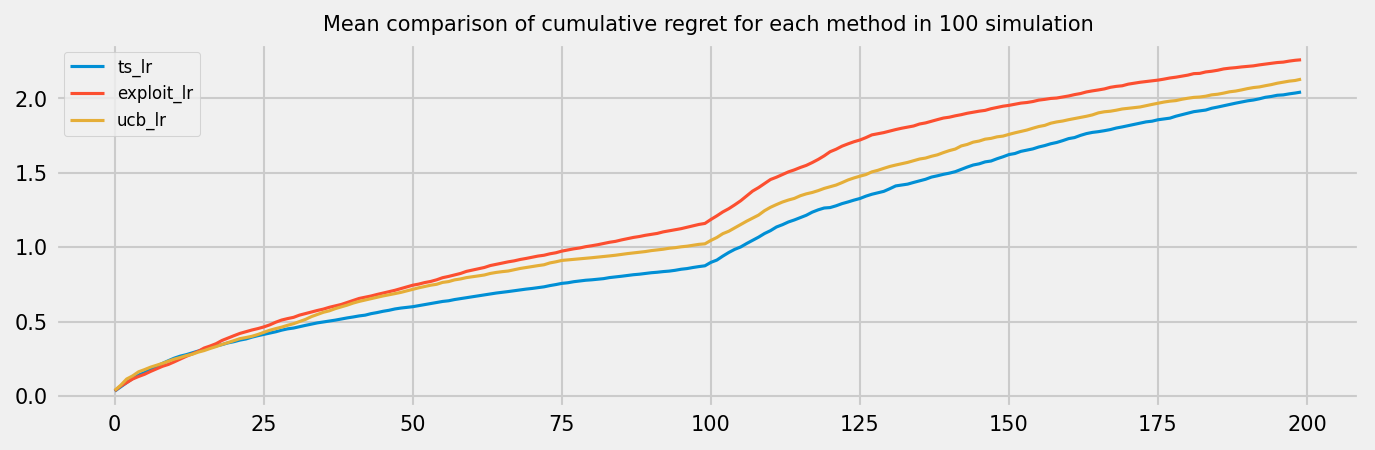

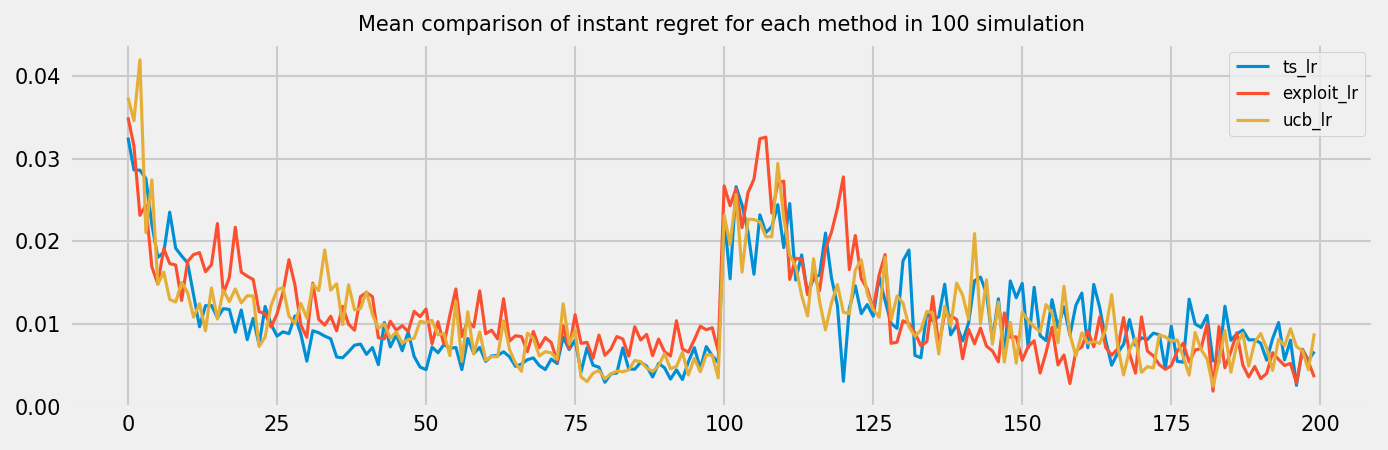

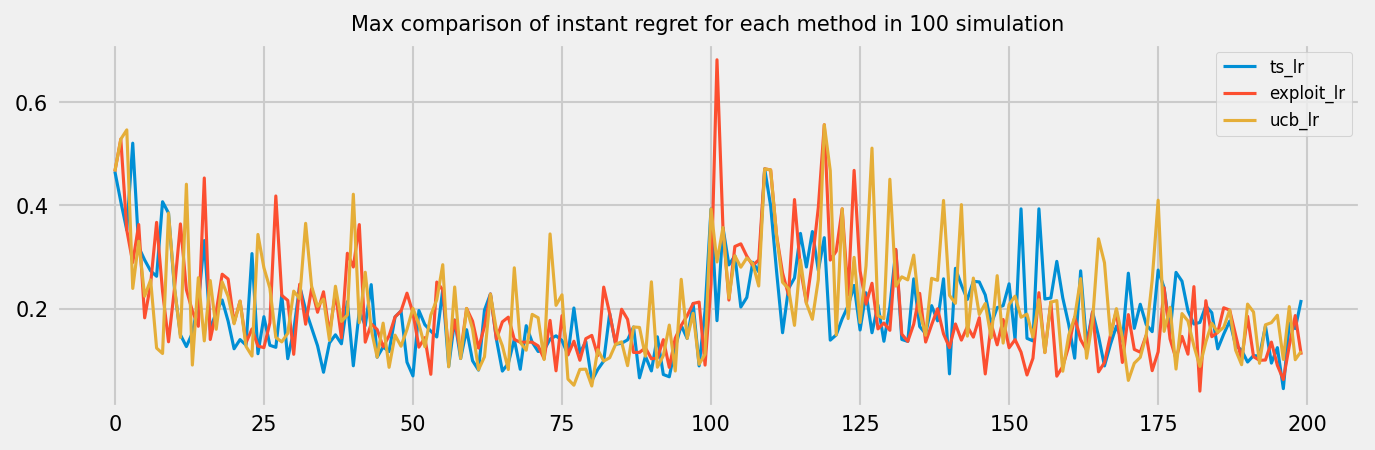

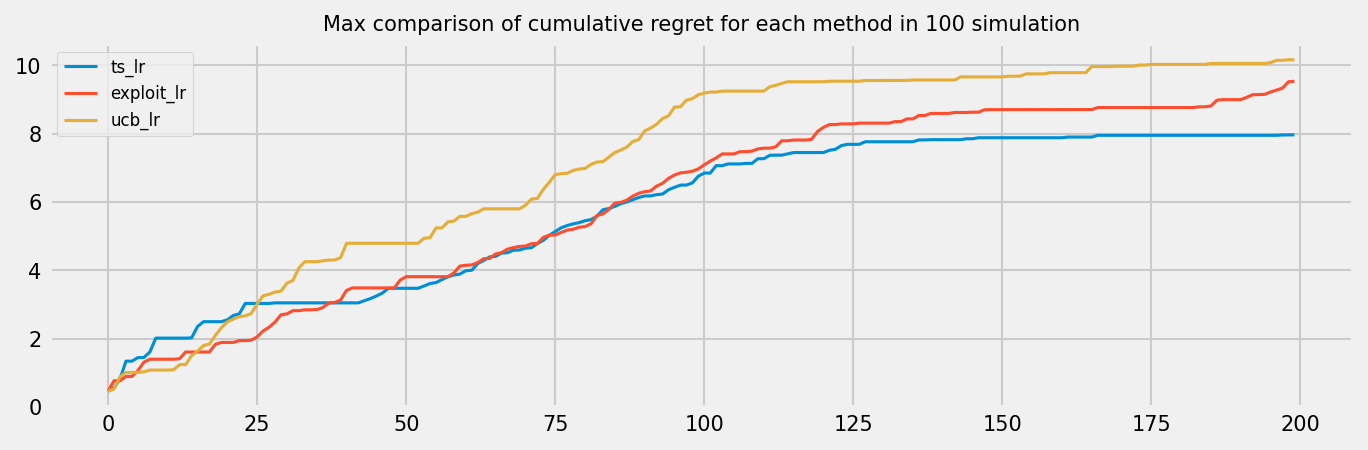

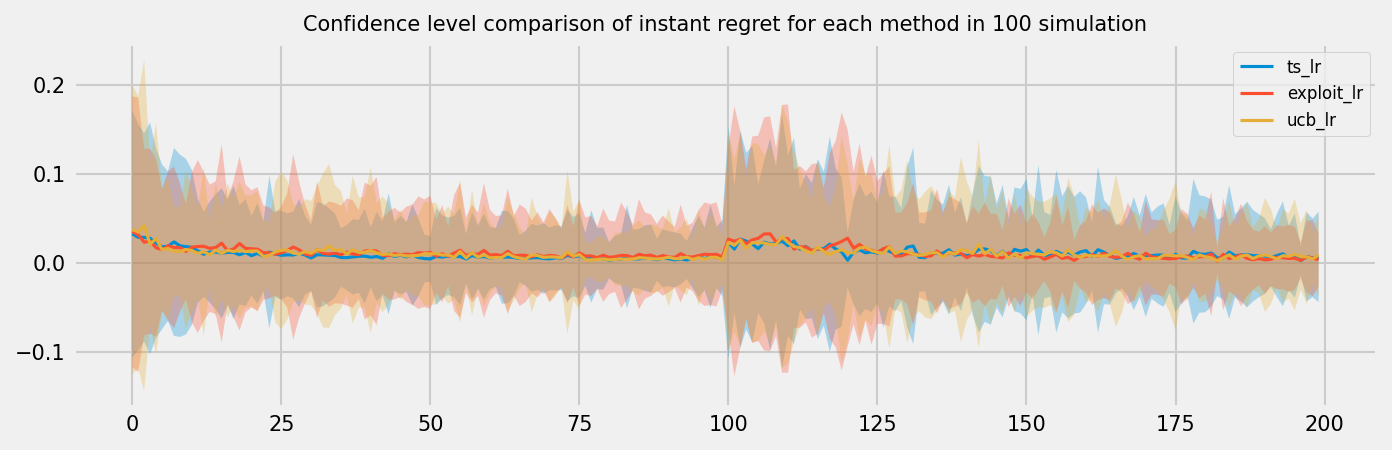

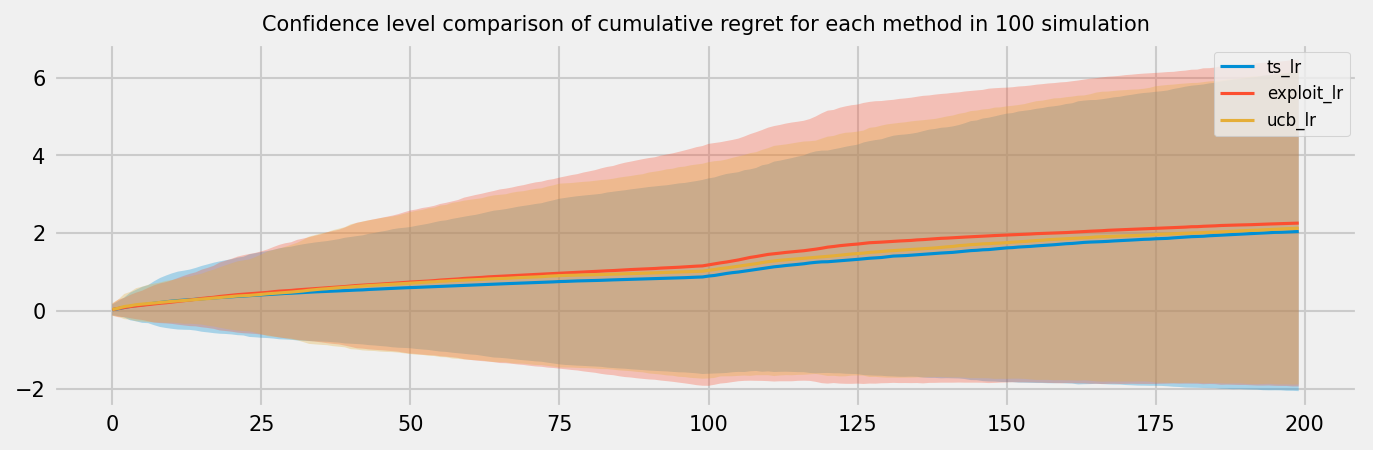

<Figure size 1500x450 with 0 Axes>

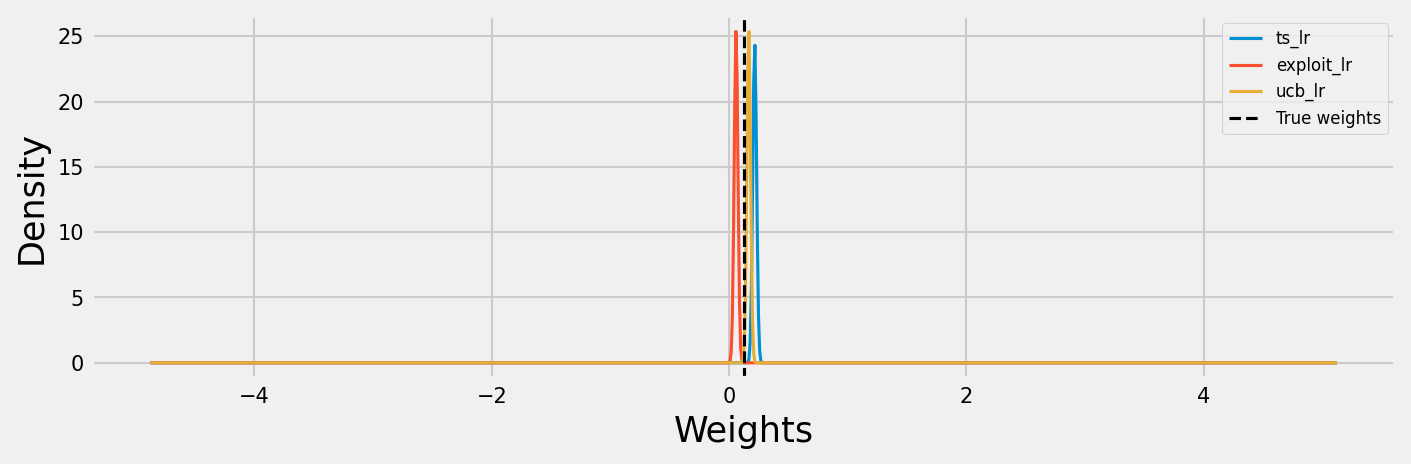

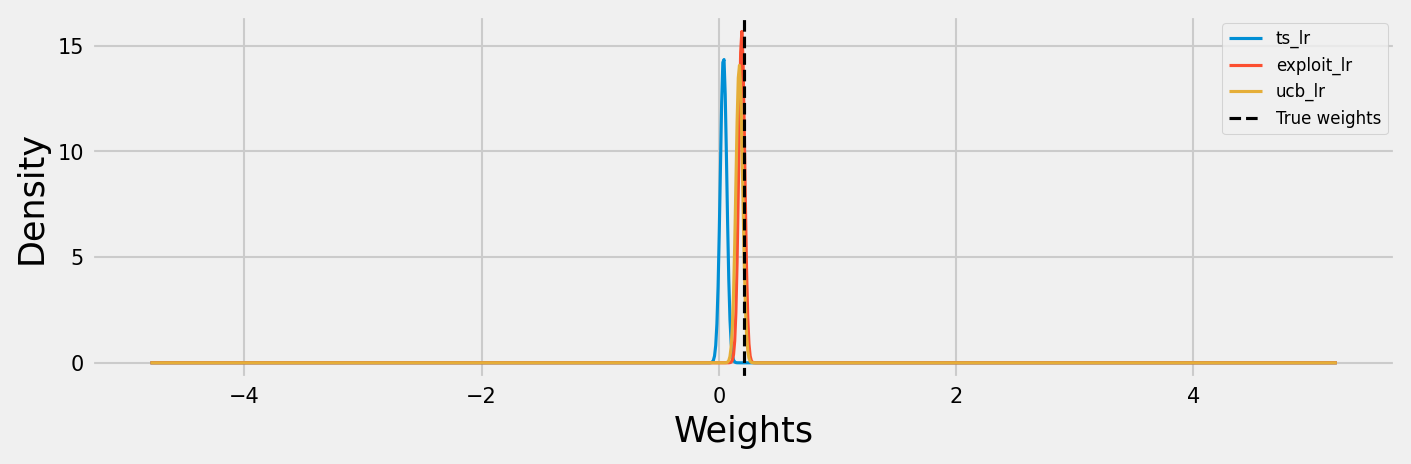

Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    2.619635
exploit_lr  199.0    2.597807
ucb_lr      199.0    2.474237
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 1 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0    4.798230
exploit_lr  199.0    2.044678
ucb_lr      199.0    6.686310
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 2 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    2.170781
exploit_lr  199.0    2.403651
ucb_lr      199.0    2.096191
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 2 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    2.950130
exploit_lr  199.0    1.983108
ucb_lr      1

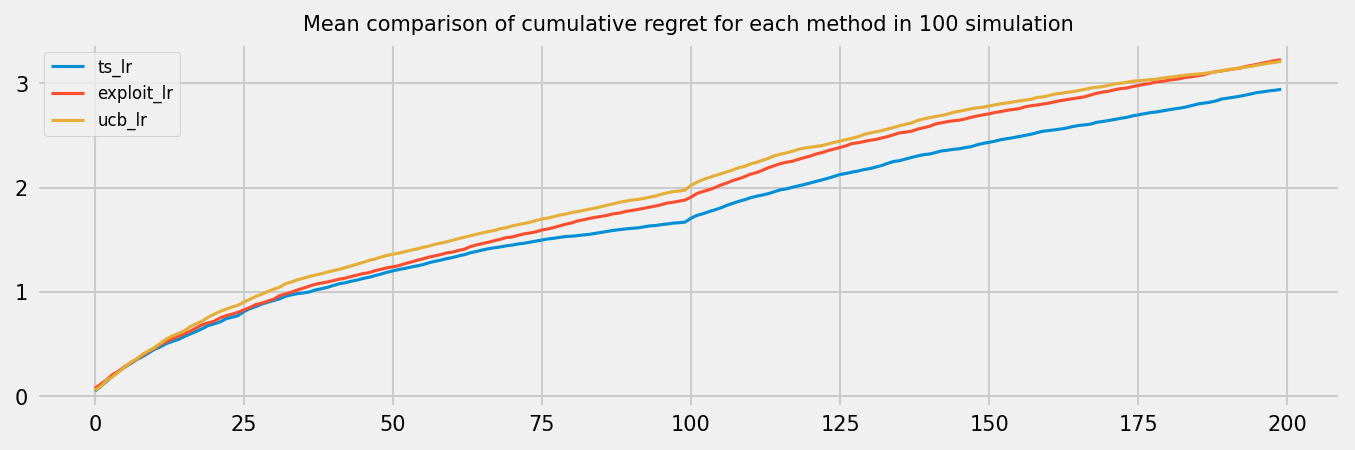

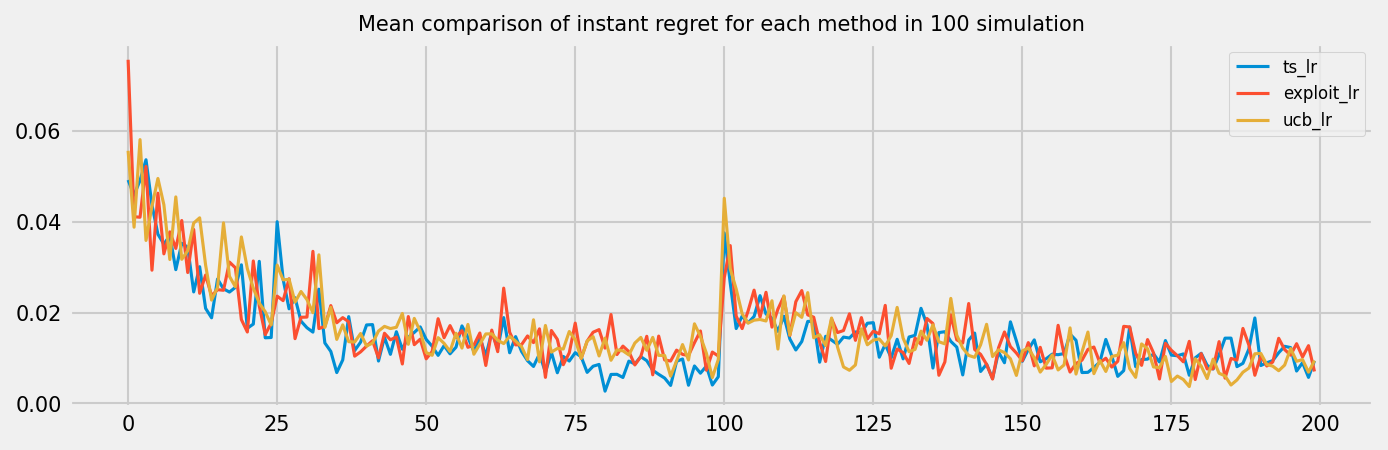

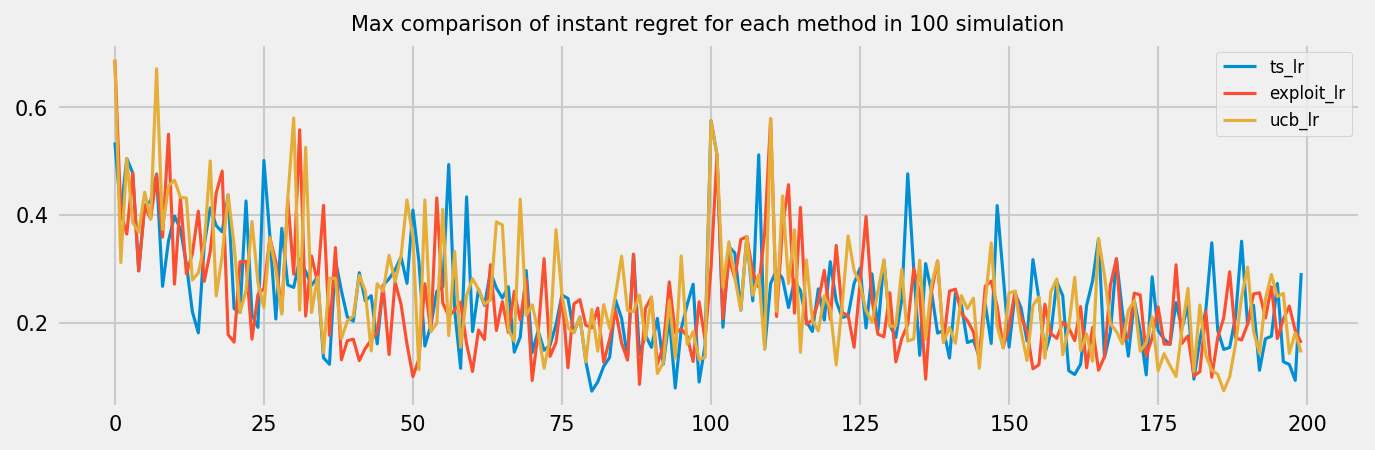

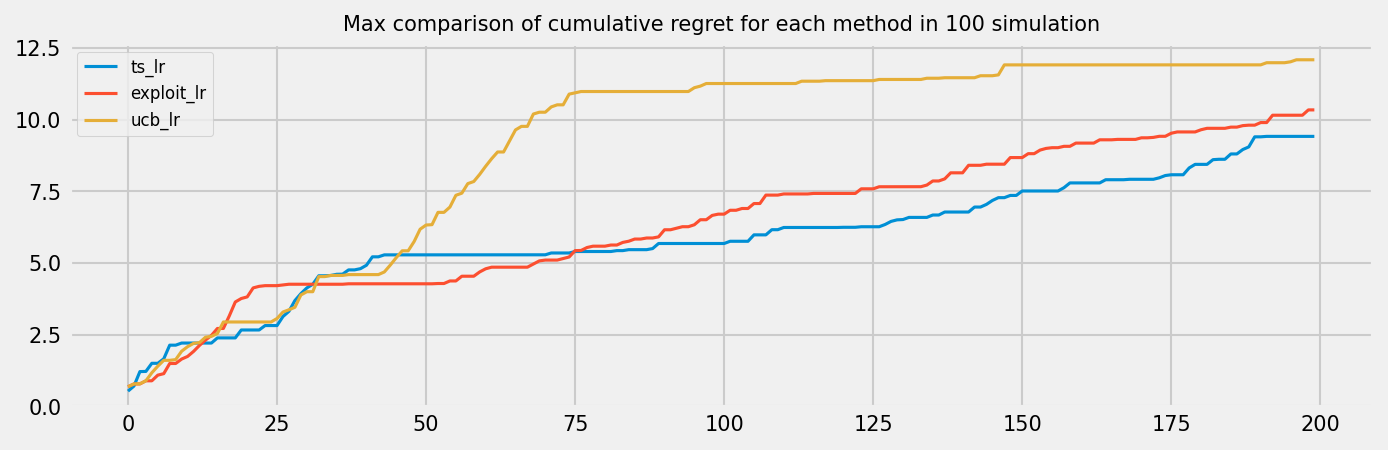

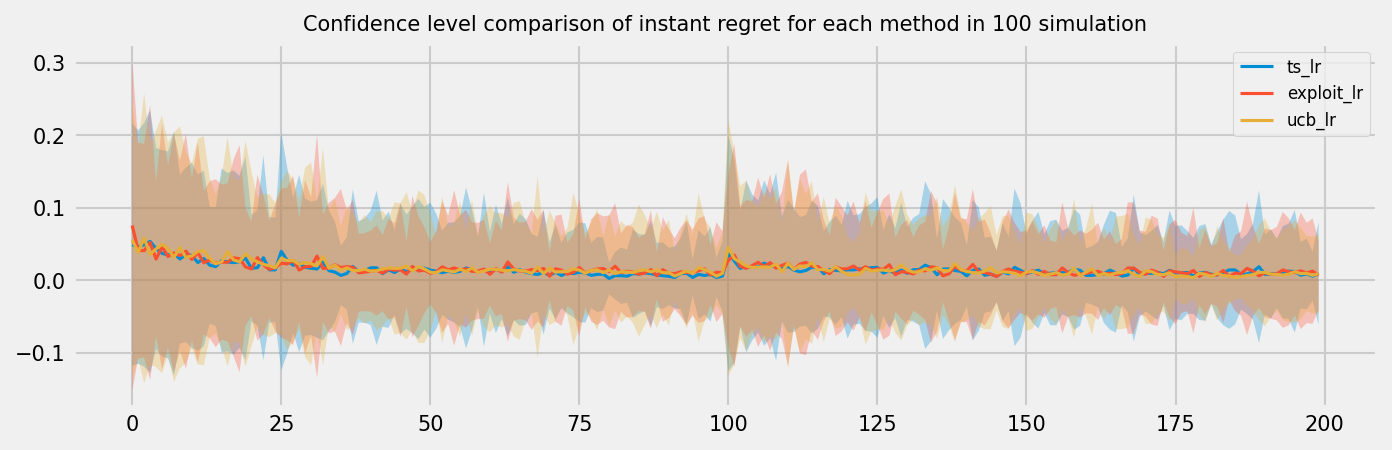

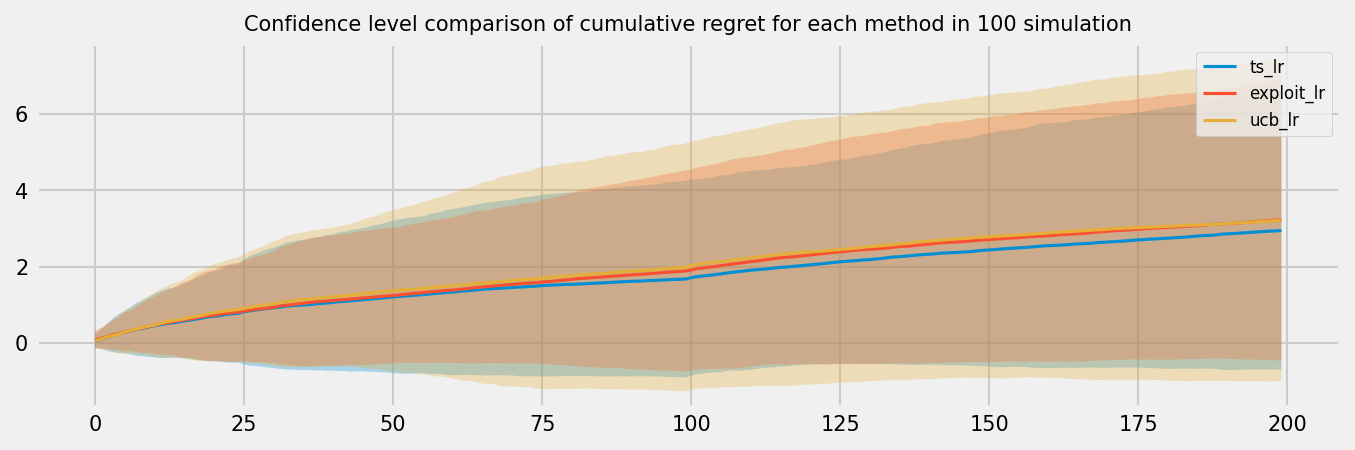

<Figure size 1500x450 with 0 Axes>

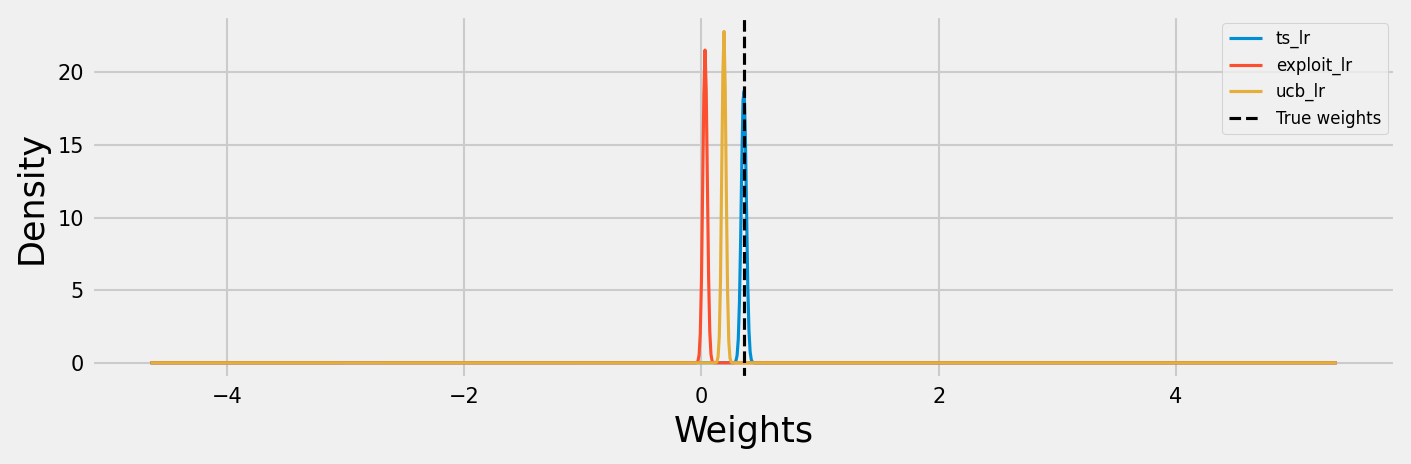

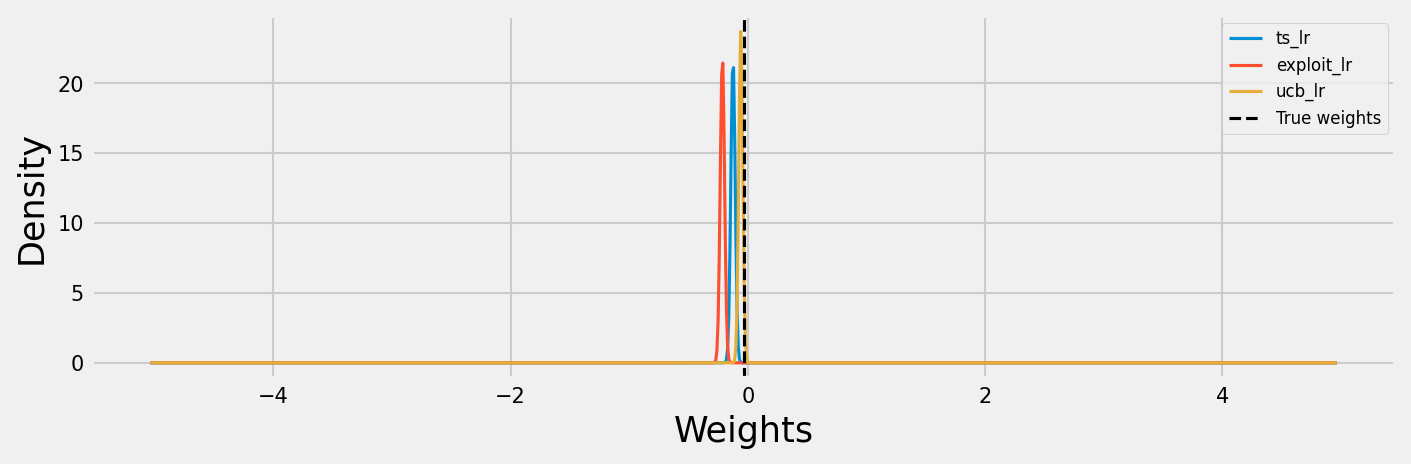

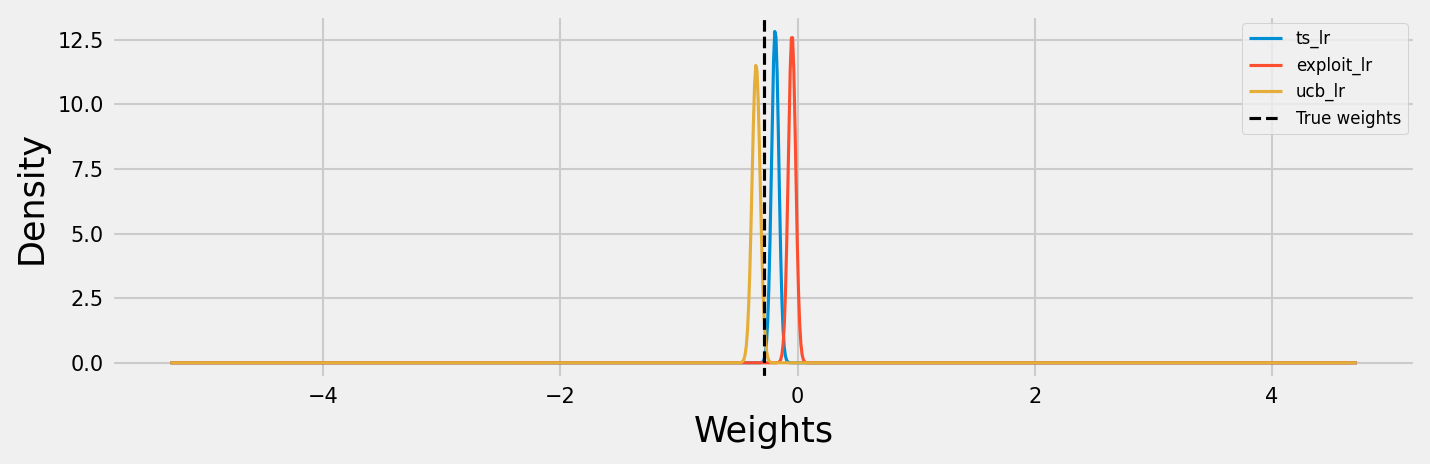

Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 2 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    3.446365
exploit_lr  199.0    3.044239
ucb_lr      199.0    3.374354
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 2 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0    6.839786
exploit_lr  199.0    2.729353
ucb_lr      199.0    9.014134
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    2.841179
exploit_lr  199.0    3.083241
ucb_lr      199.0    2.635825
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    3.557480
exploit_lr  199.0    2.474737
ucb_lr      1

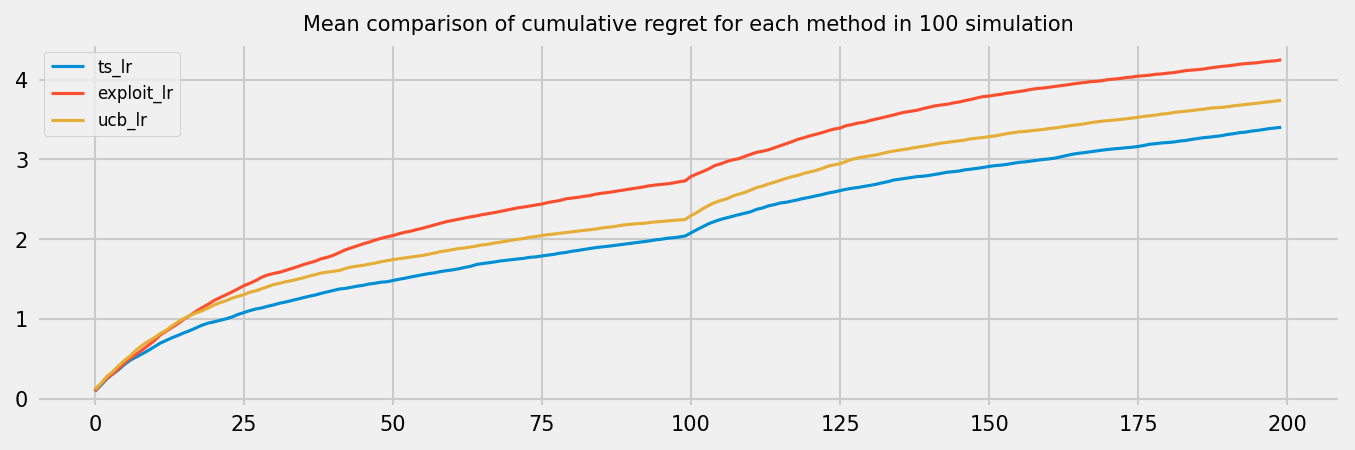

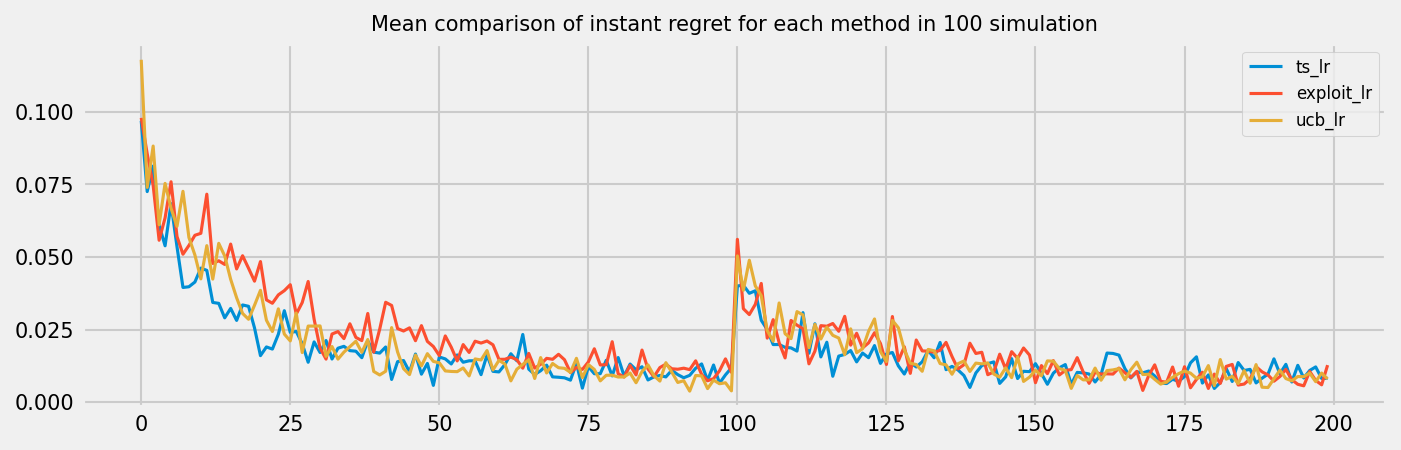

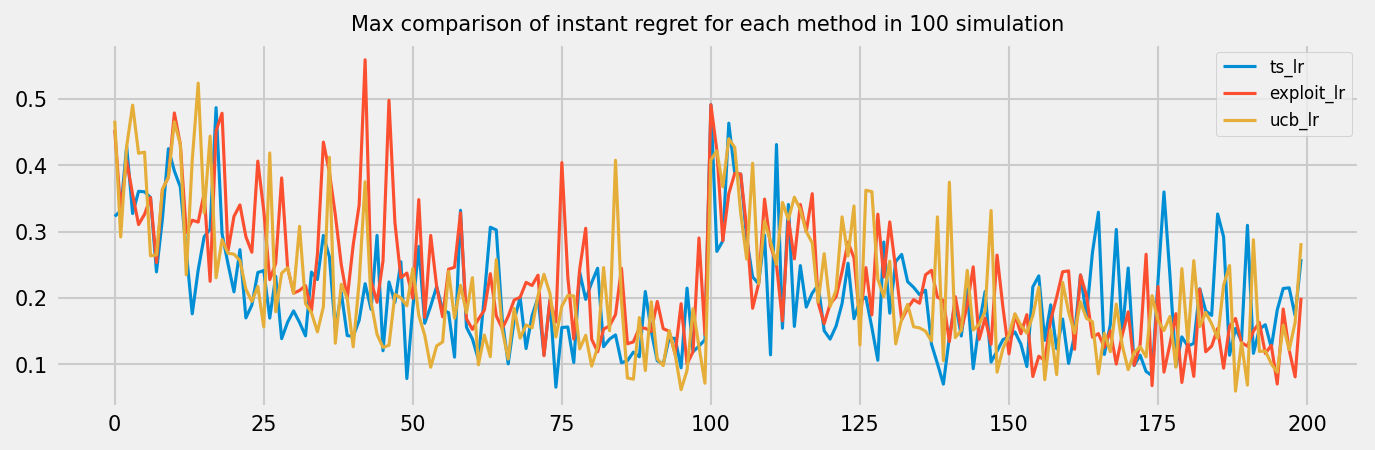

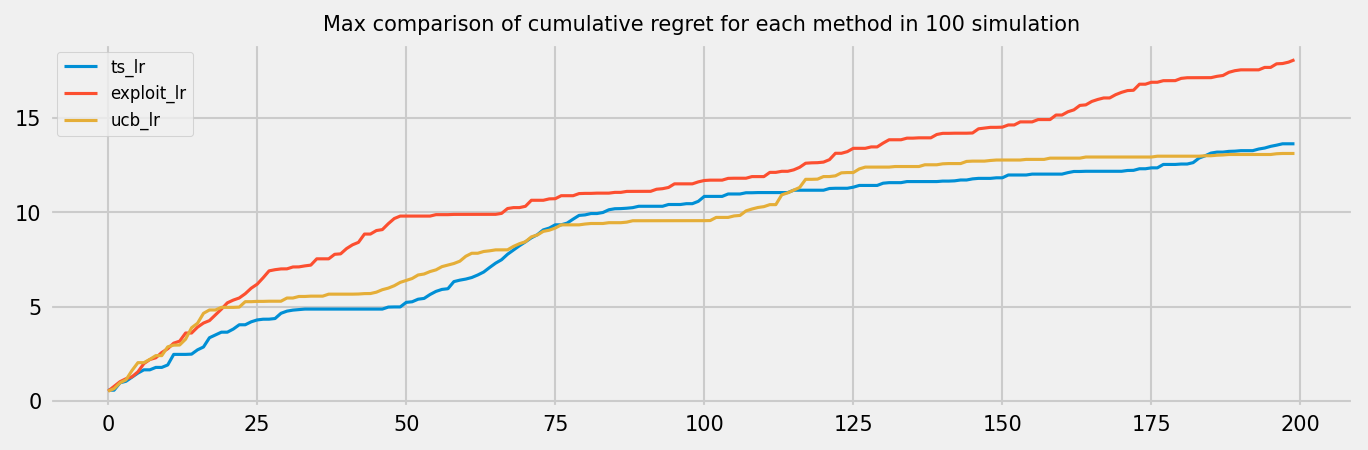

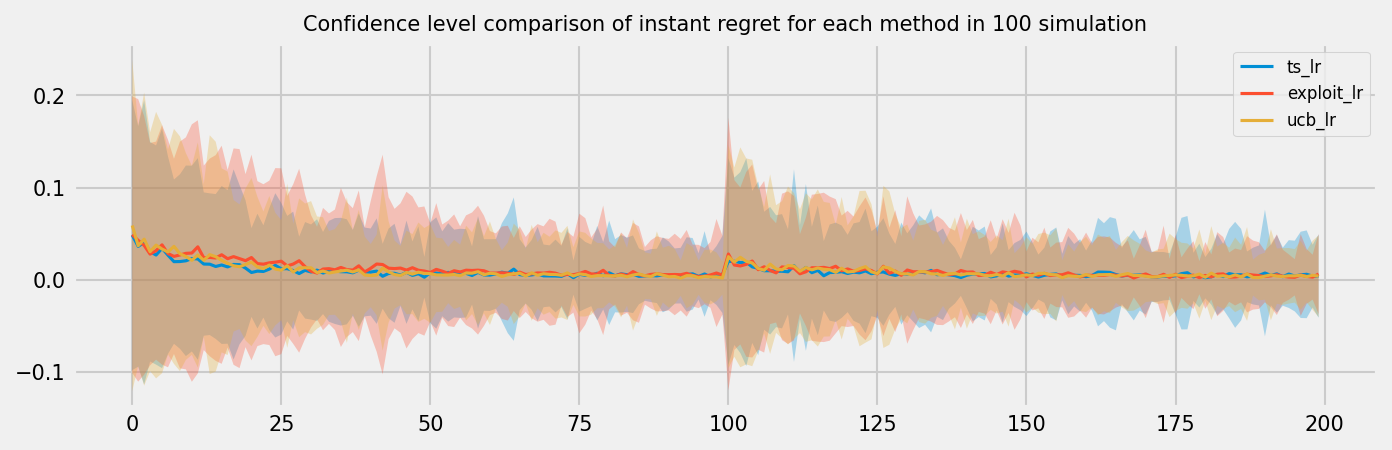

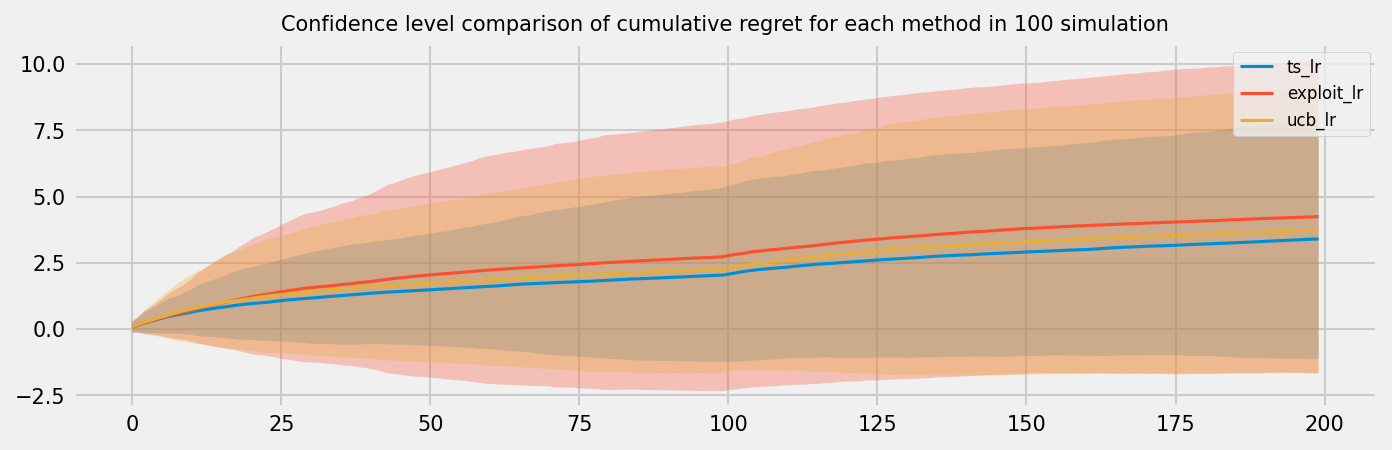

<Figure size 1500x450 with 0 Axes>

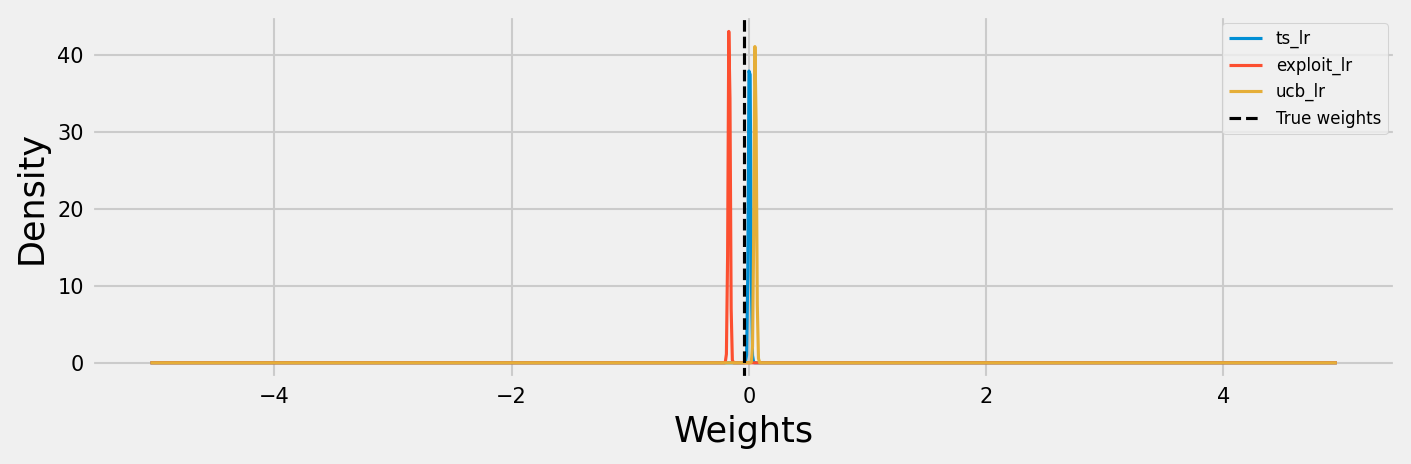

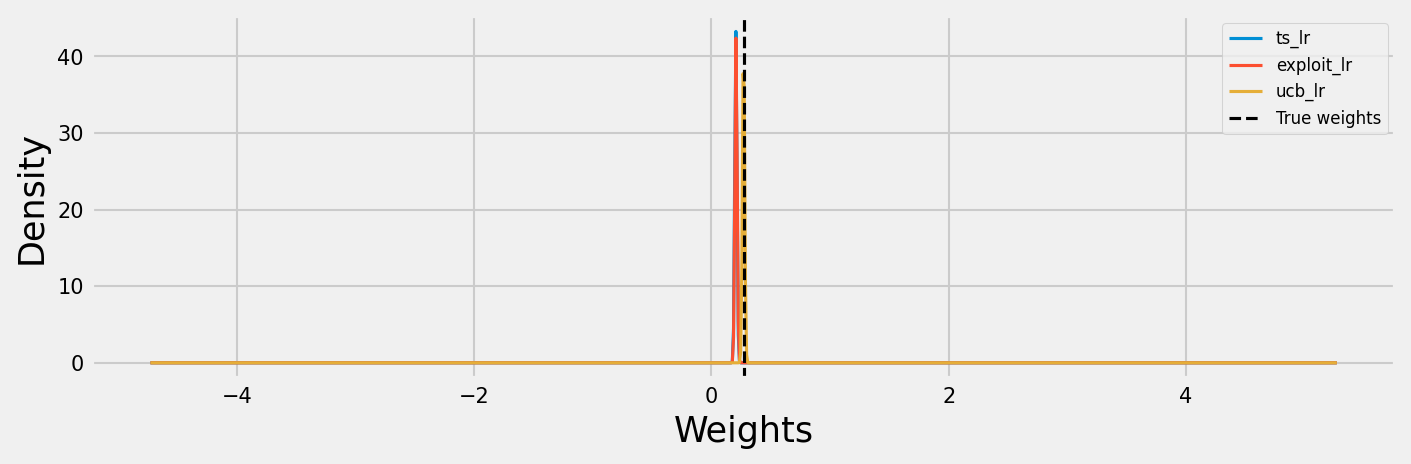

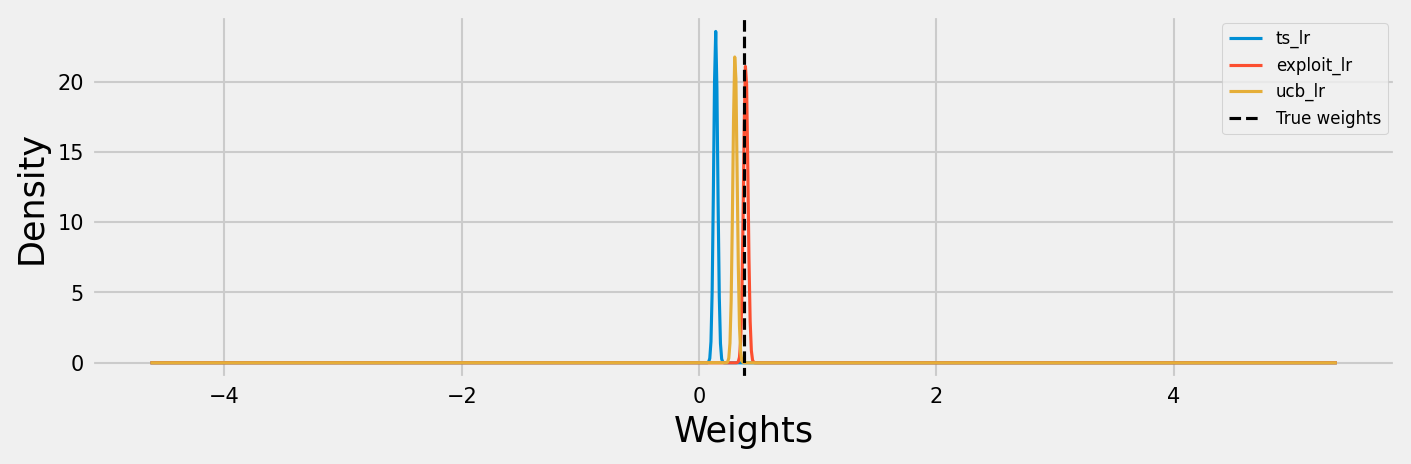

Analyzing simulation with 2 arms, 2 data points per round, 100 rounds, 2 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    4.052894
exploit_lr  199.0    3.901787
ucb_lr      199.0    4.536464
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 2 data points per round, 100 rounds, 2 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0     9.580824
exploit_lr  199.0     3.792710
ucb_lr      199.0    16.674419
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 2 data points per round, 100 rounds, 3 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    3.367413
exploit_lr  199.0    3.041430
ucb_lr      199.0    2.988717
Name: regret_cumsum, dtype: float64
Analyzing simulation with 2 arms, 2 data points per round, 100 rounds, 3 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    3.820093
exploit_lr  199.0    3.070544
ucb_lr    

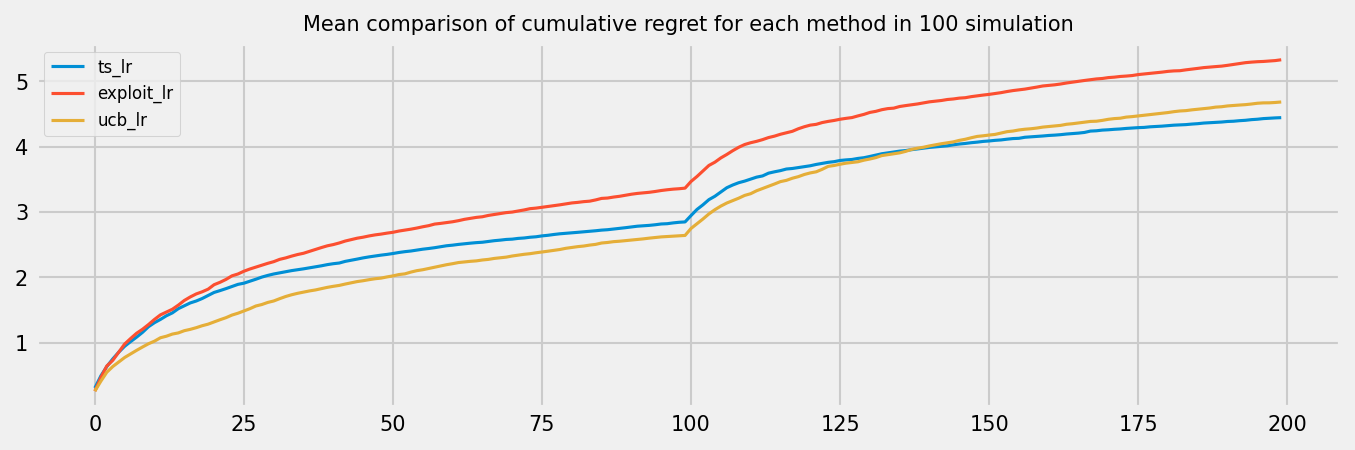

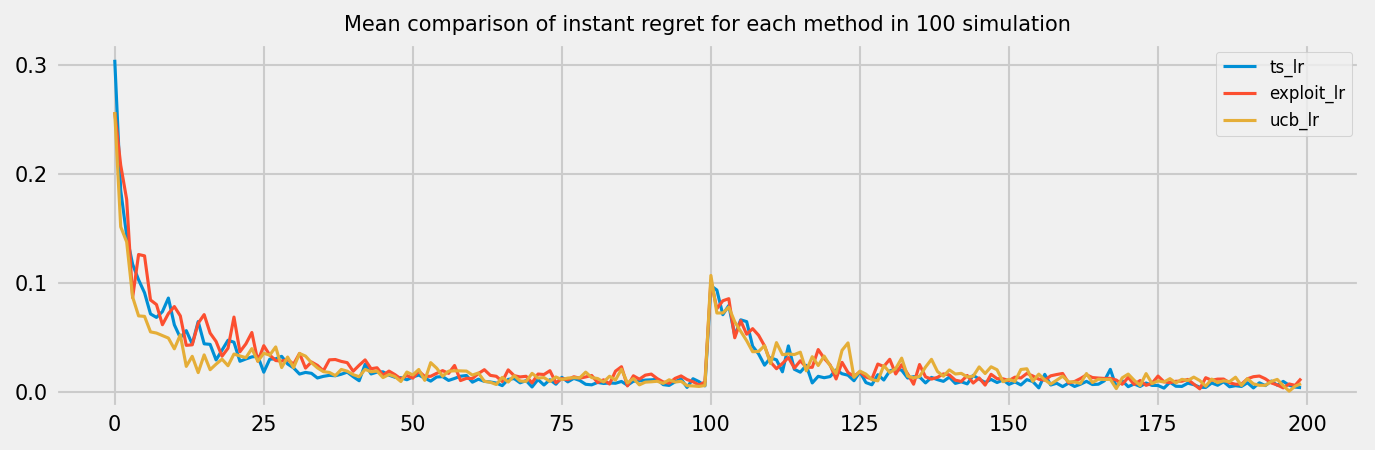

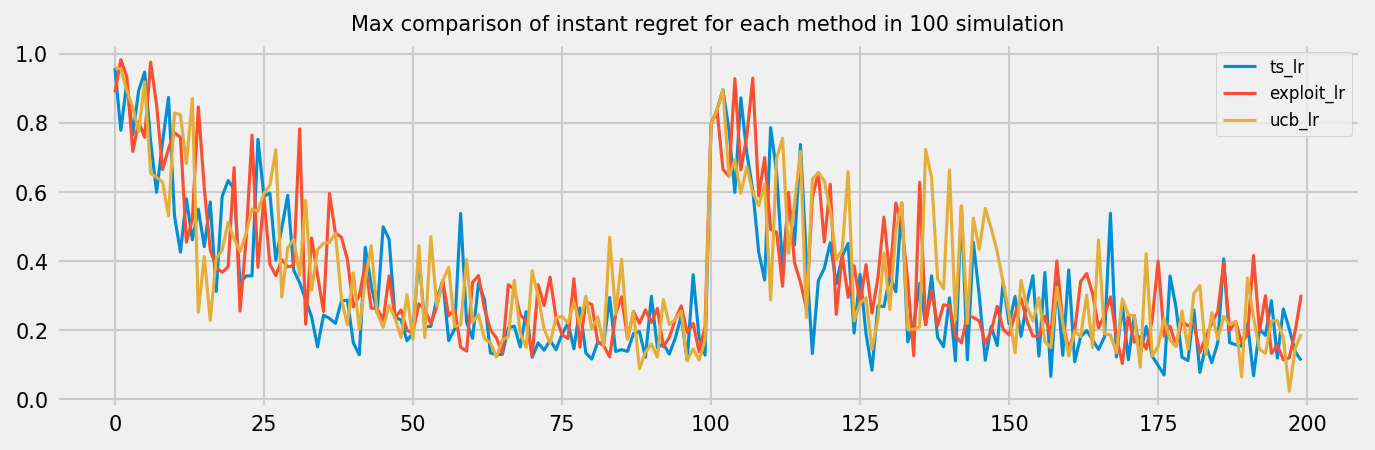

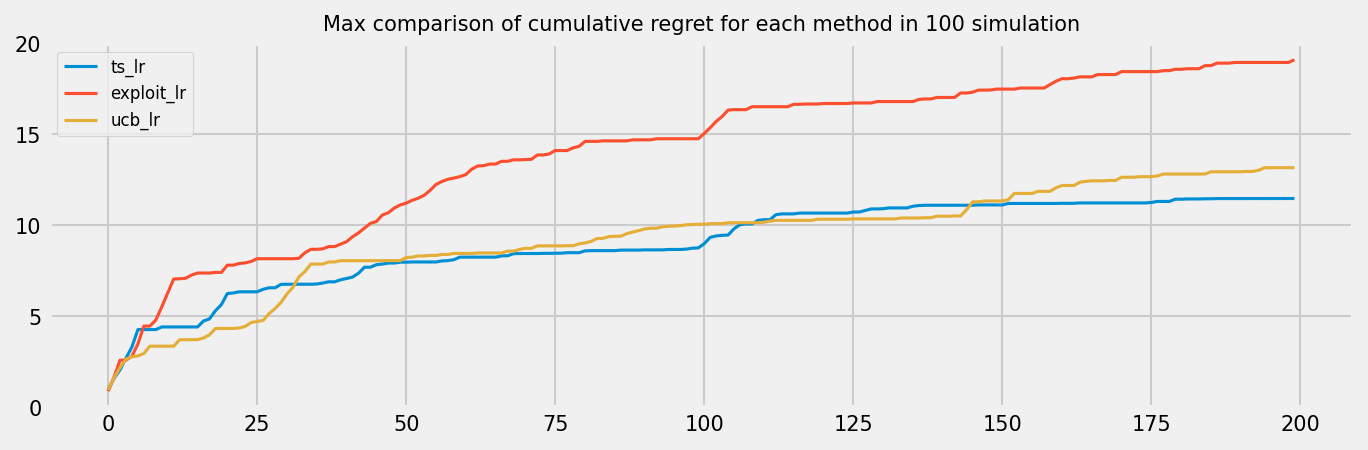

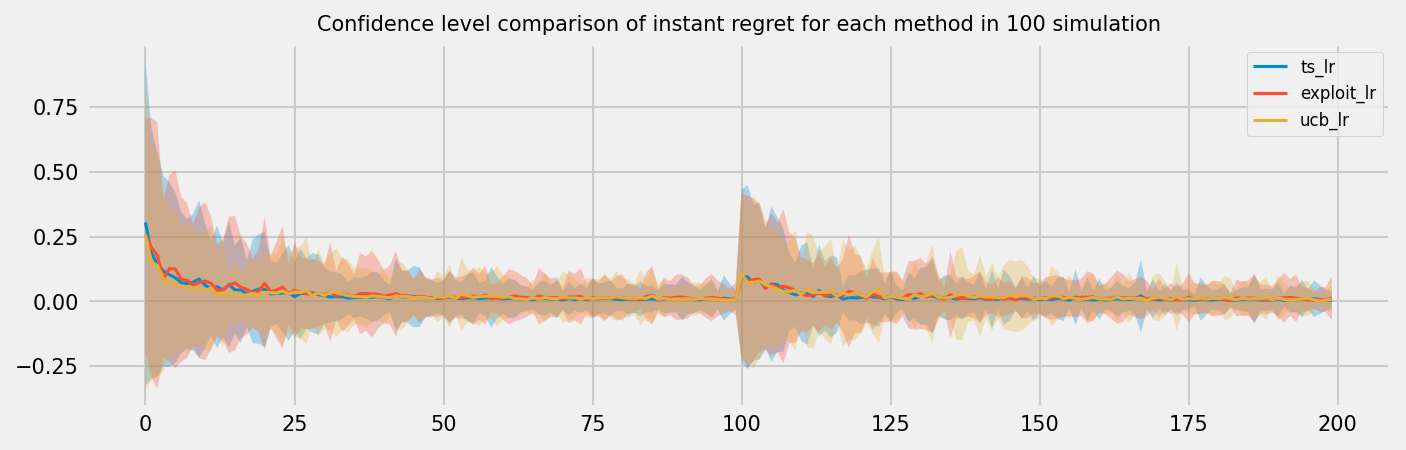

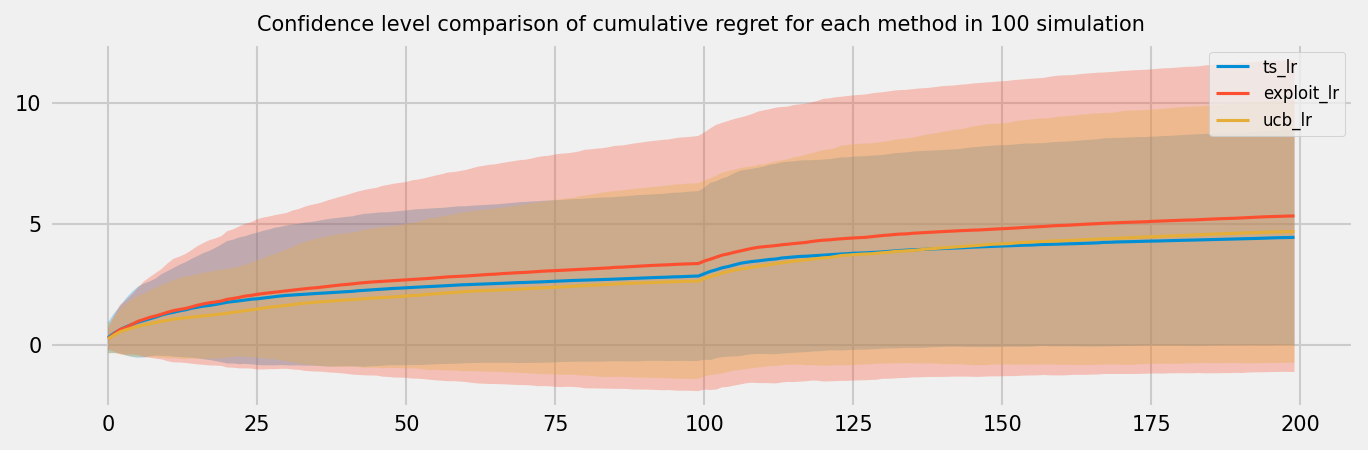

<Figure size 1500x450 with 0 Axes>

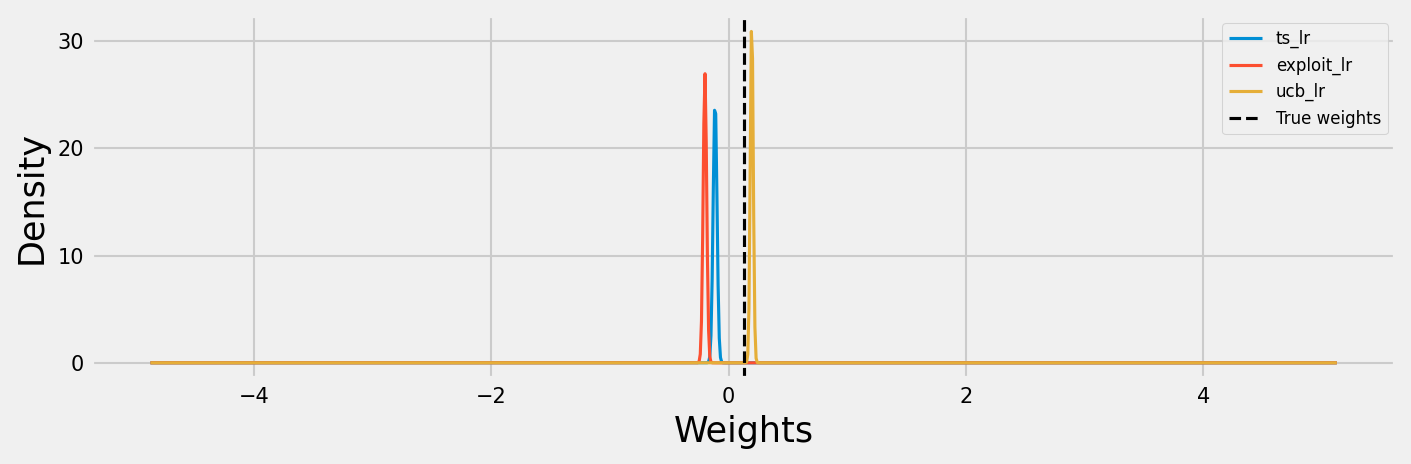

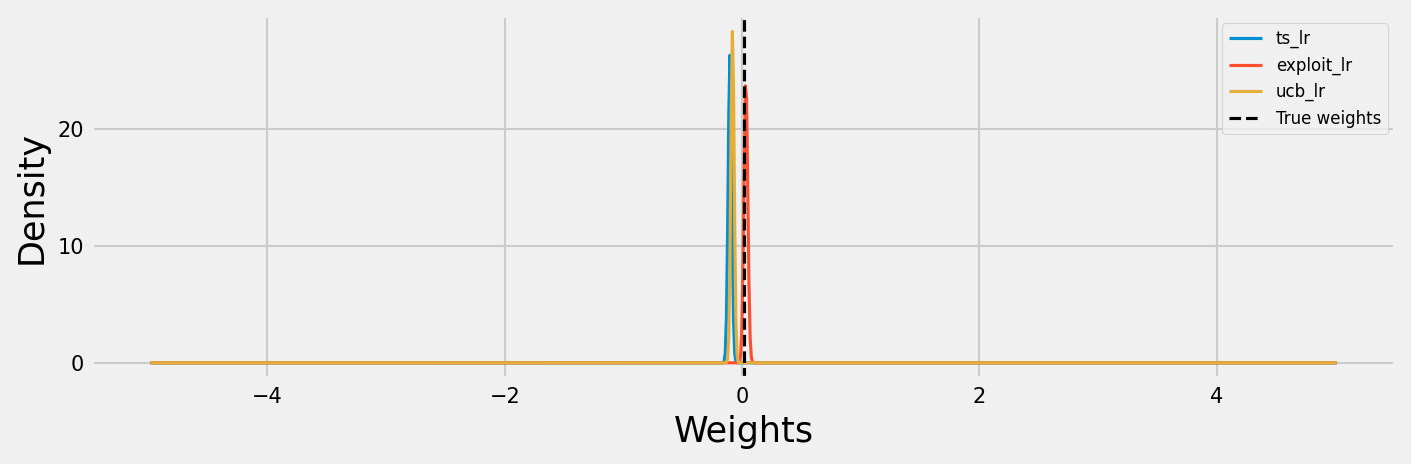

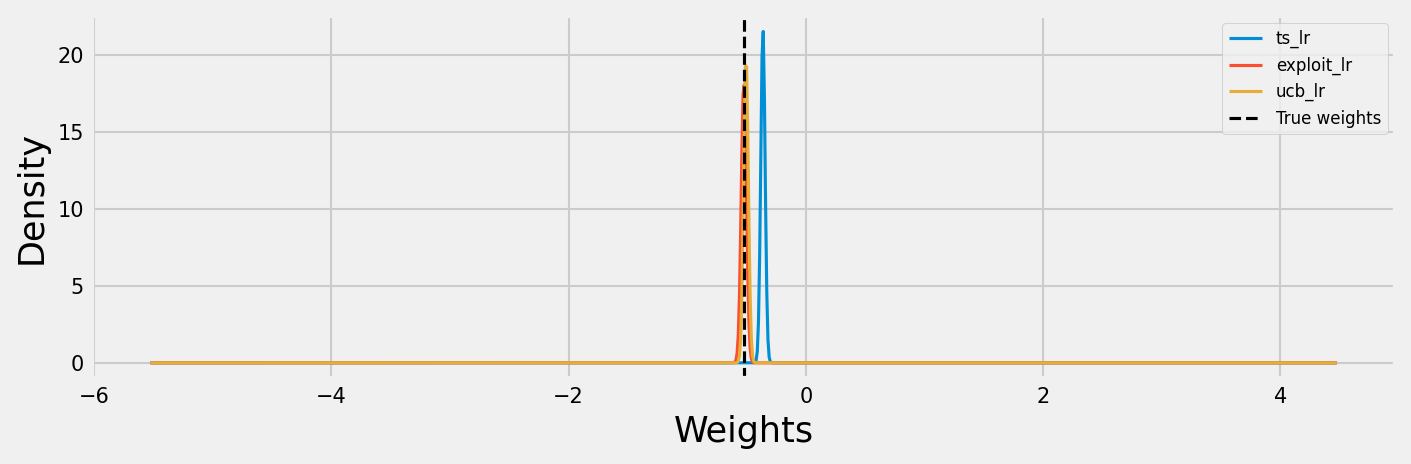

Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 2 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    5.574083
exploit_lr  199.0    4.707178
ucb_lr      199.0    4.505936
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 2 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    19.546720
exploit_lr  199.0     4.358391
ucb_lr      199.0    17.331214
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 2 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    7.696151
exploit_lr  199.0    7.226560
ucb_lr      199.0    7.131662
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 2 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    6.983000
exploit_lr  199.0    6.531224
ucb_lr

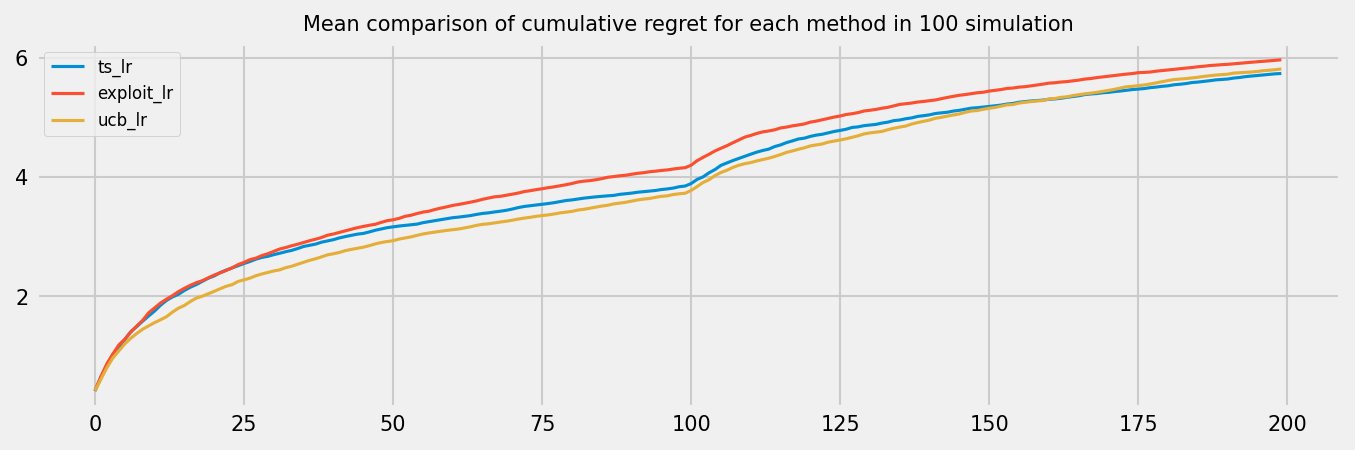

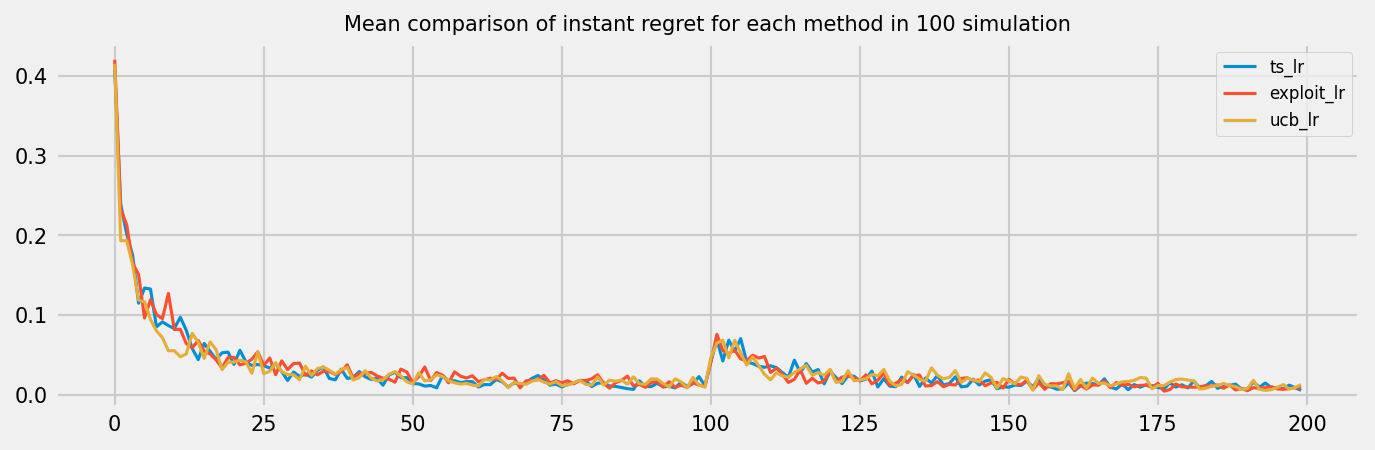

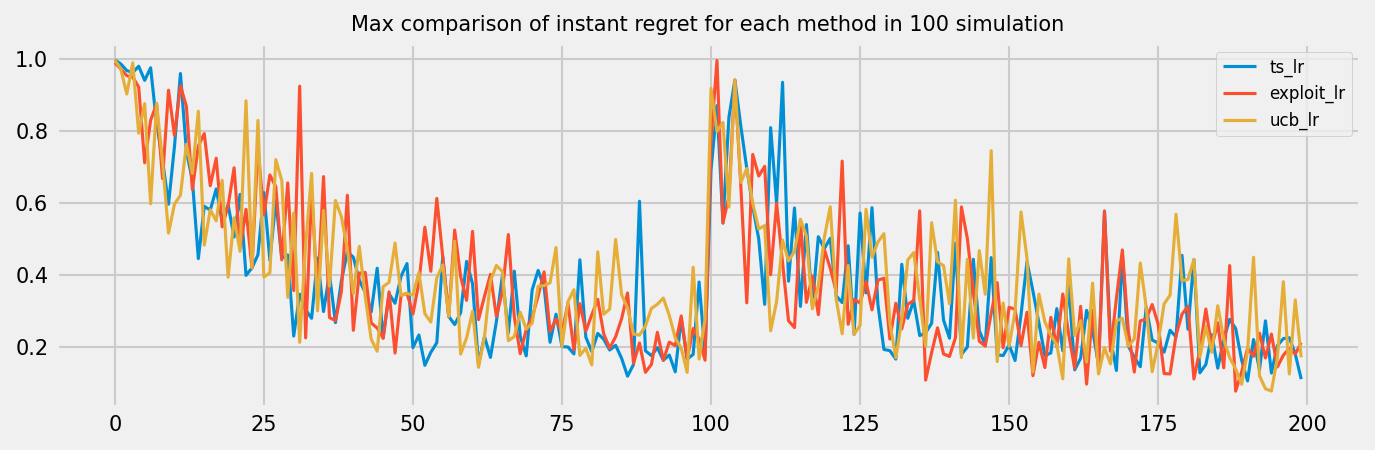

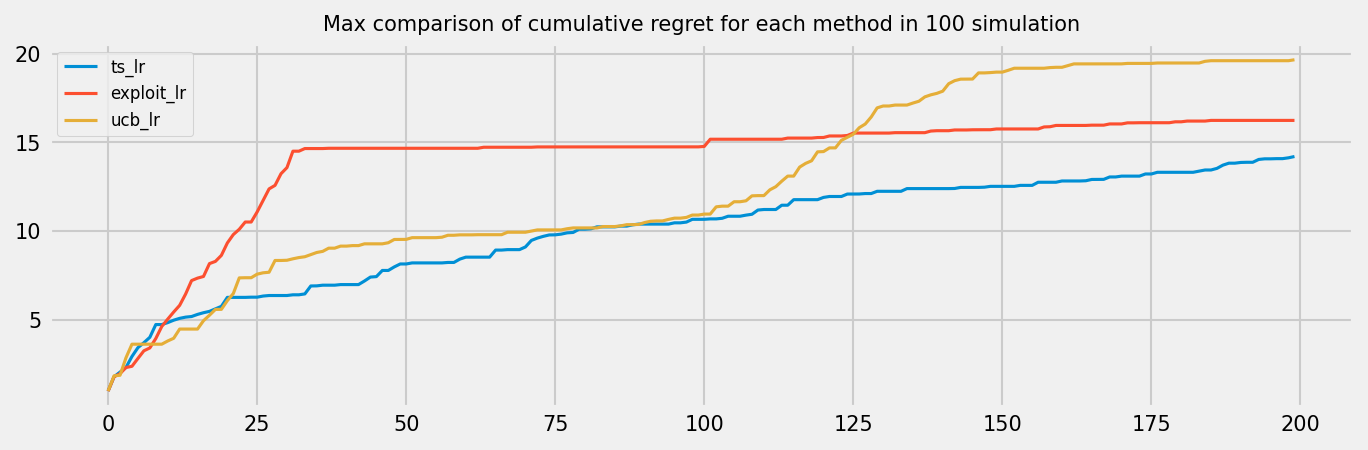

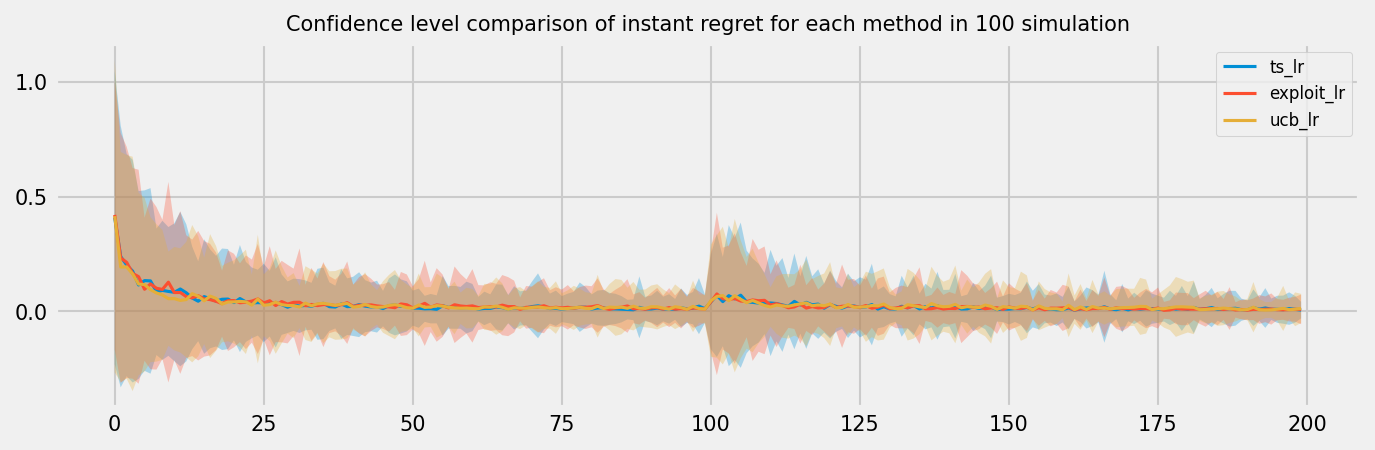

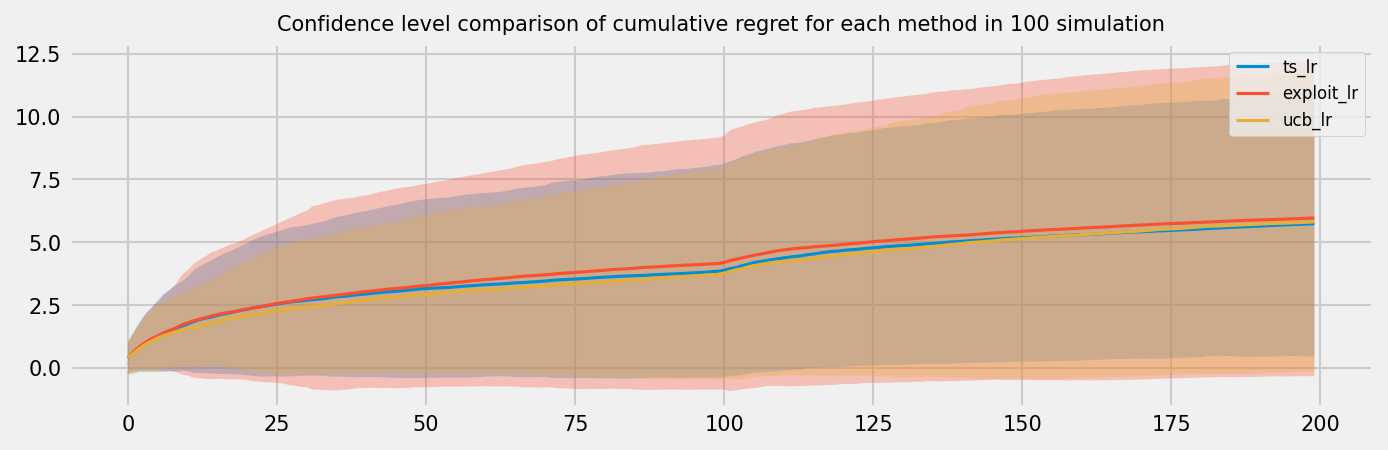

<Figure size 1500x450 with 0 Axes>

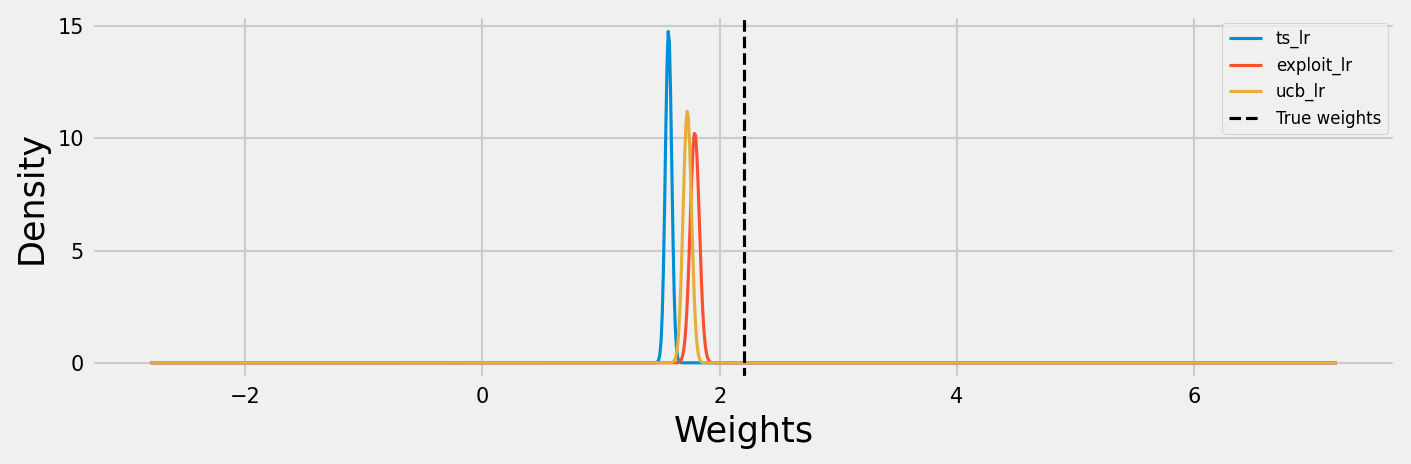

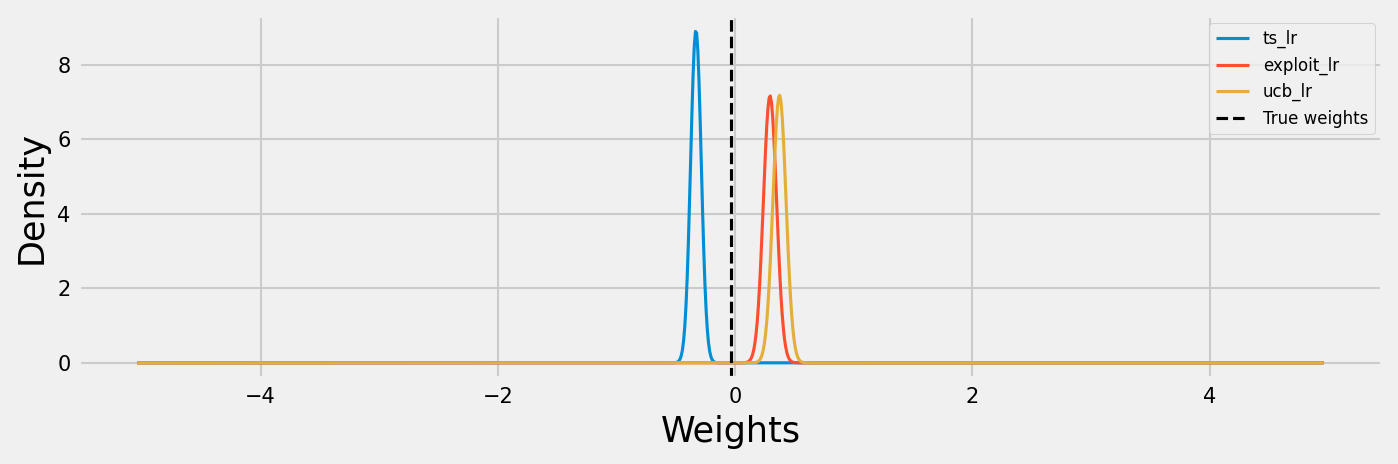

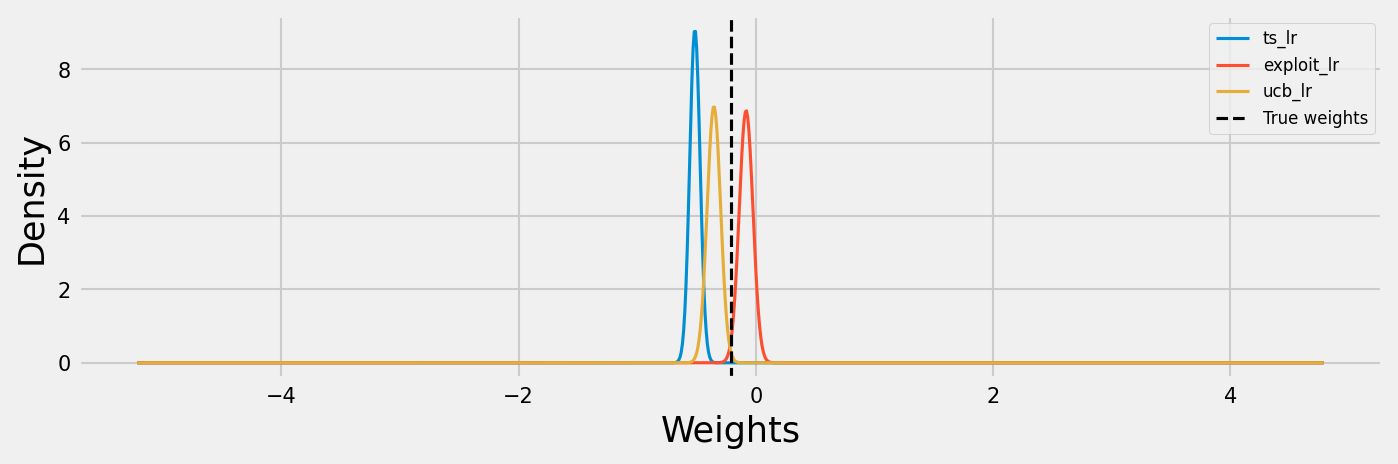

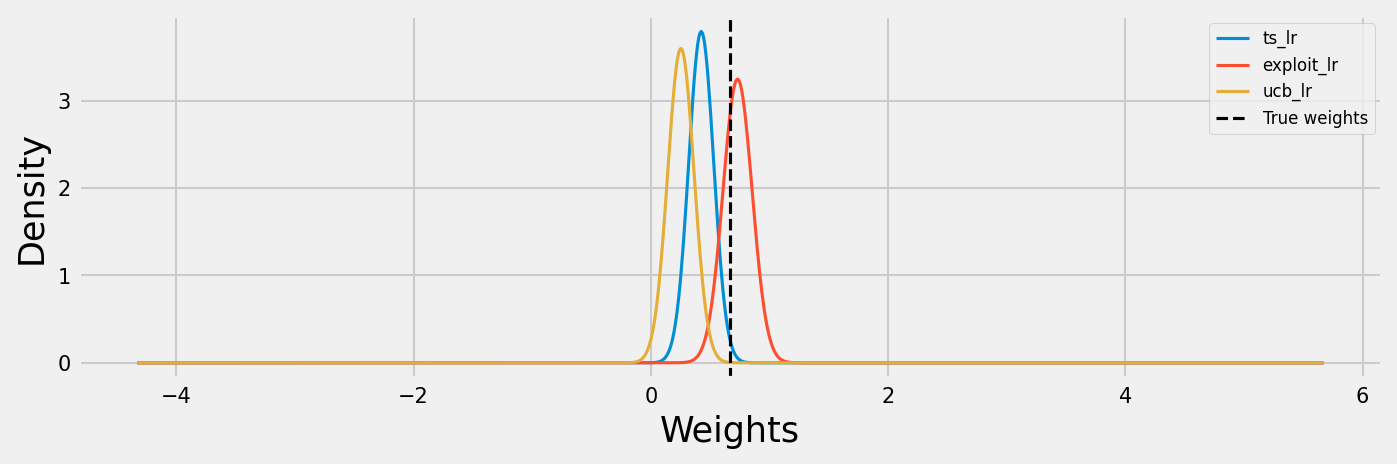

Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    6.655593
exploit_lr  199.0    6.212123
ucb_lr      199.0    6.193221
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 1, alpha 10, 100 simulations
policy      round
ts_lr       199.0    24.698273
exploit_lr  199.0     5.635609
ucb_lr      199.0    20.262530
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 10, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    8.897518
exploit_lr  199.0    8.536020
ucb_lr      199.0    8.715794
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 1 data points per round, 100 rounds, 3 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    8.319569
exploit_lr  199.0    8.487978
ucb_lr

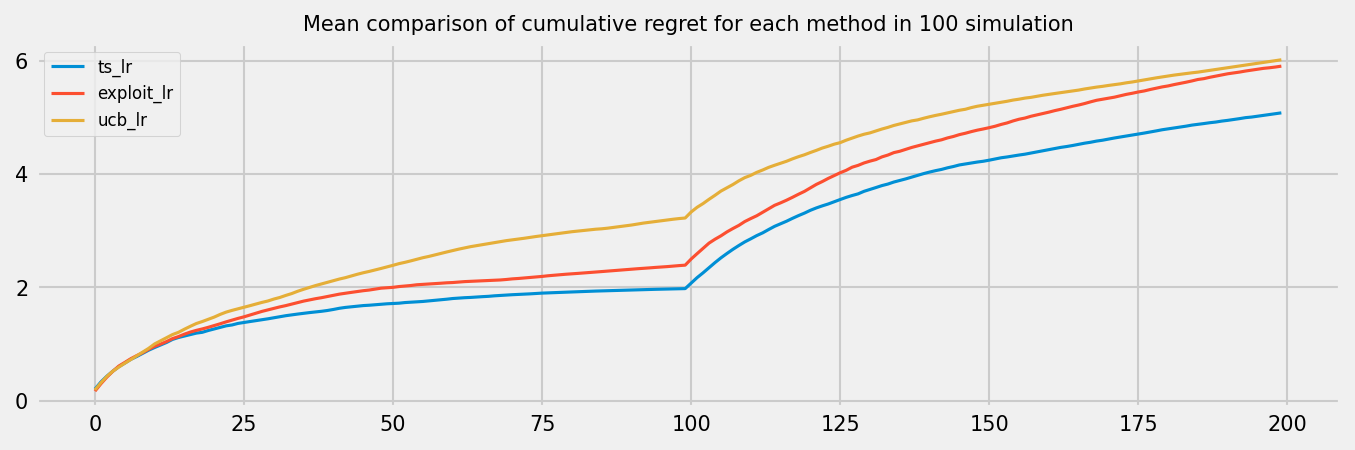

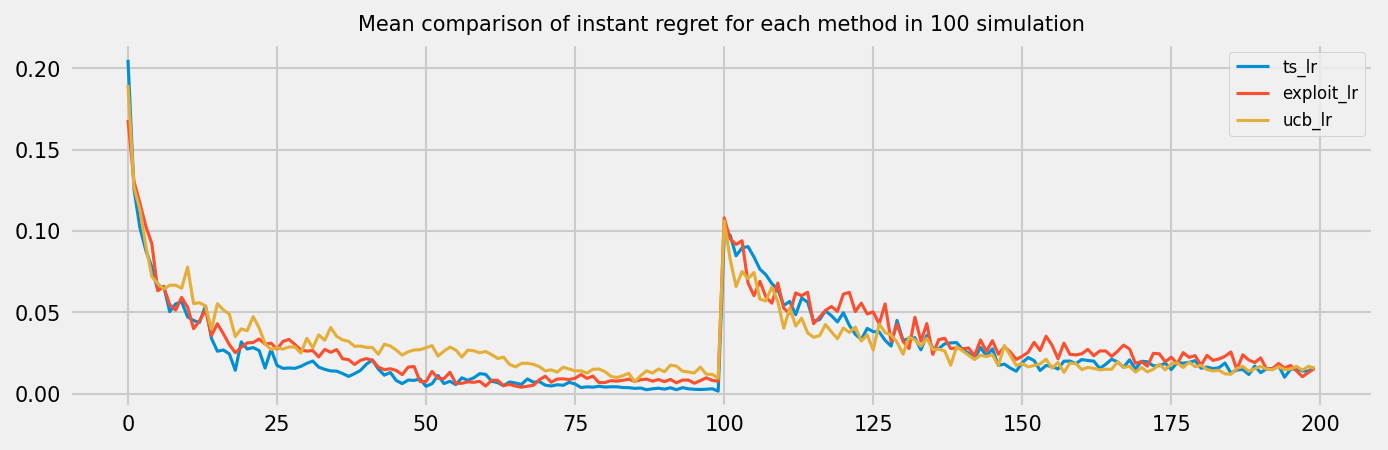

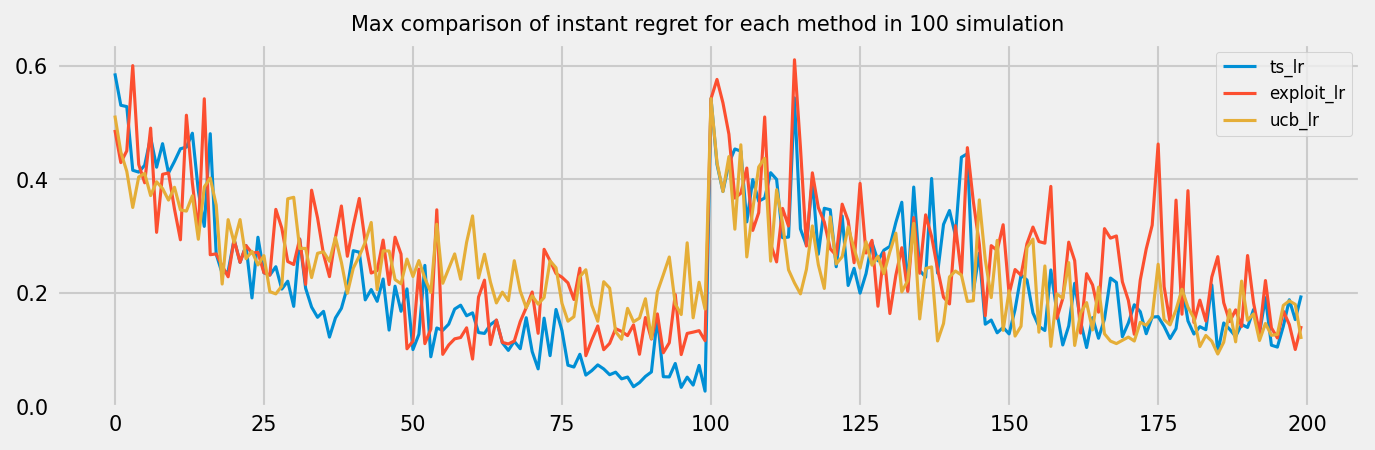

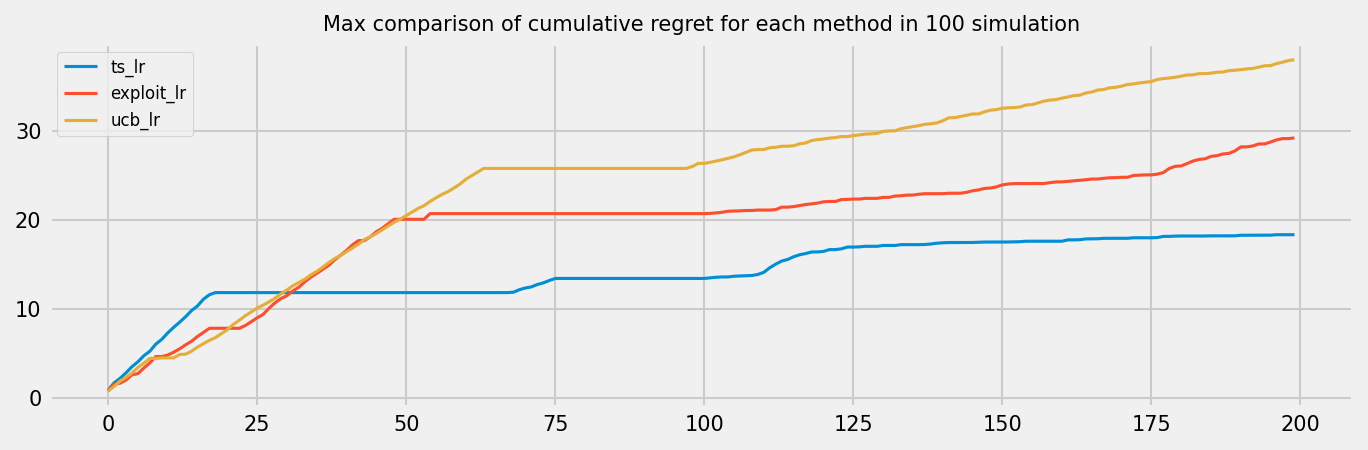

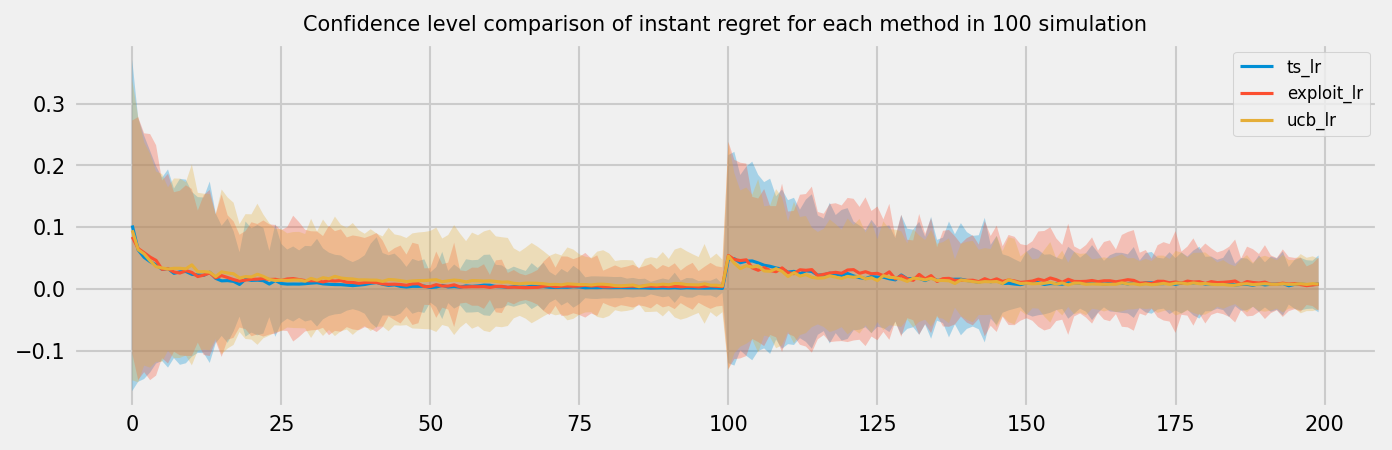

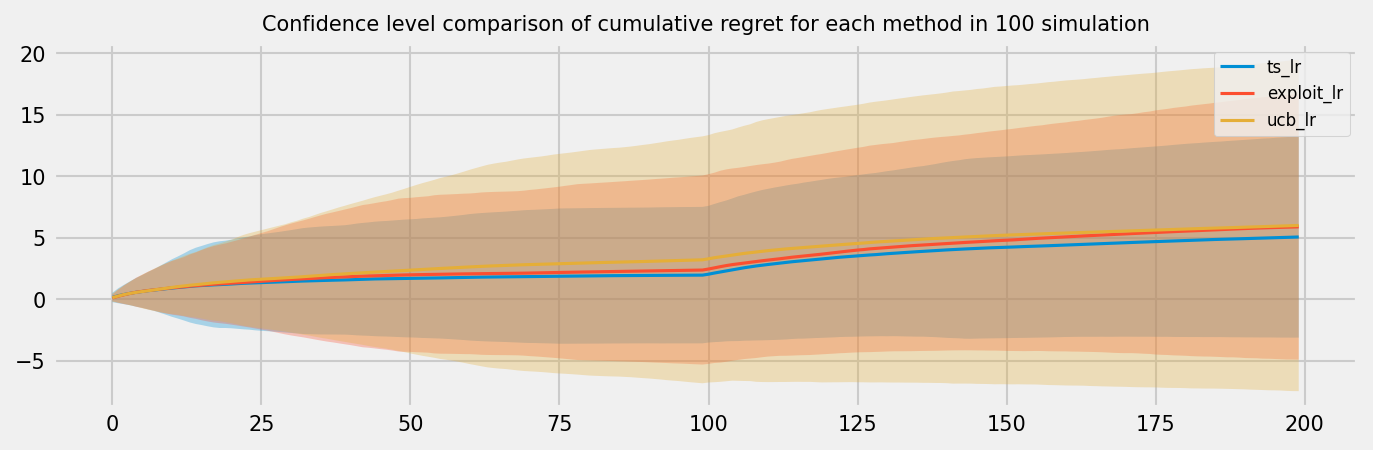

<Figure size 1500x450 with 0 Axes>

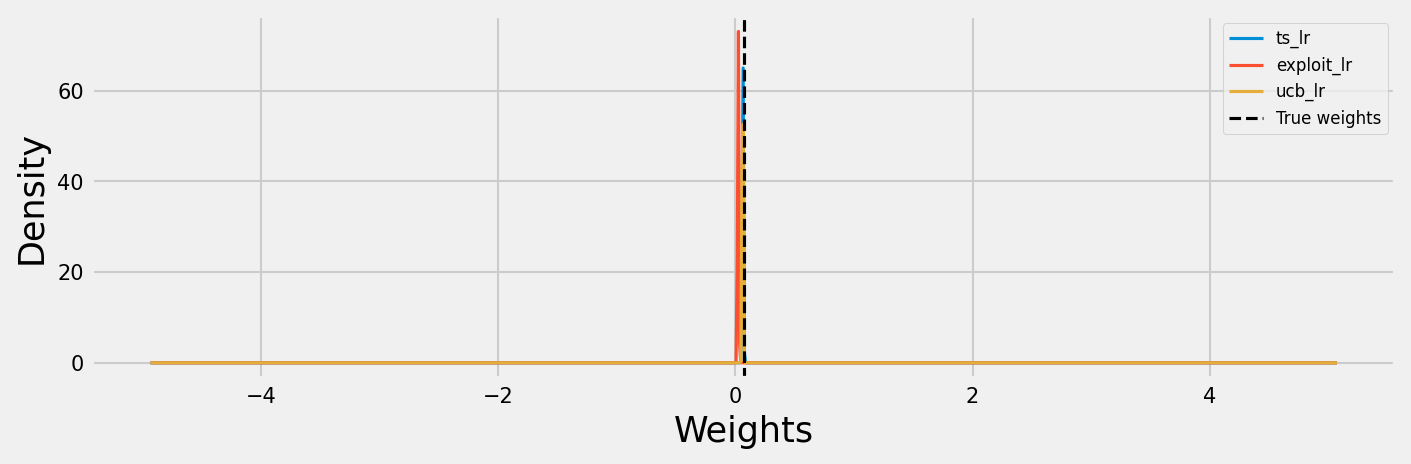

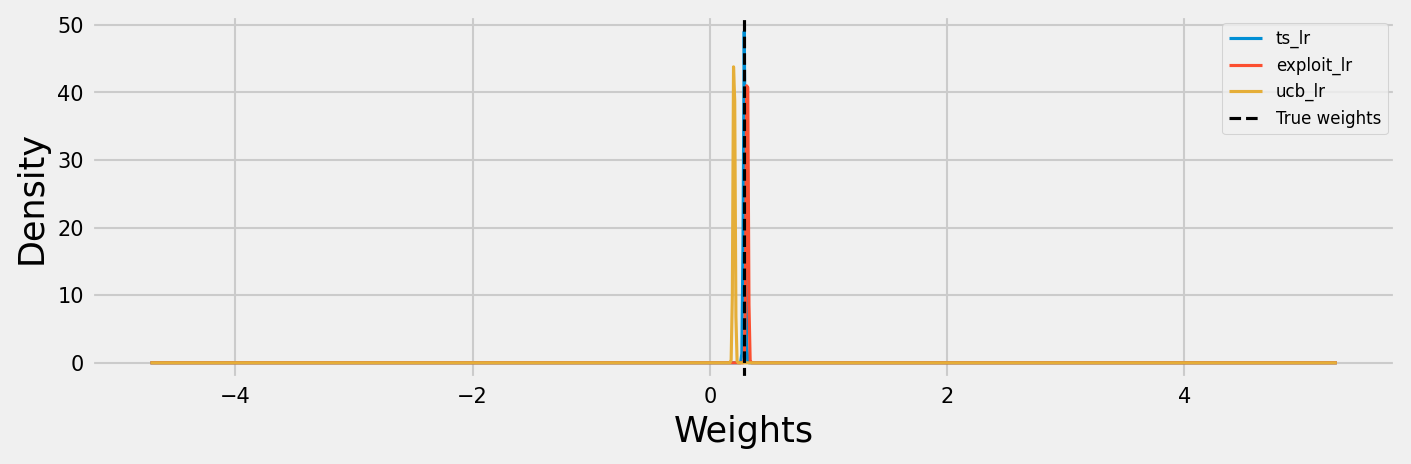

Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 1 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    6.326073
exploit_lr  199.0    5.586337
ucb_lr      199.0    4.896441
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 1 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0    10.827154
exploit_lr  199.0     4.189644
ucb_lr      199.0    17.842276
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 2 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    6.206057
exploit_lr  199.0    5.612017
ucb_lr      199.0    5.773525
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 2 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    7.610788
exploit_lr  199.0    6.170677
ucb_lr

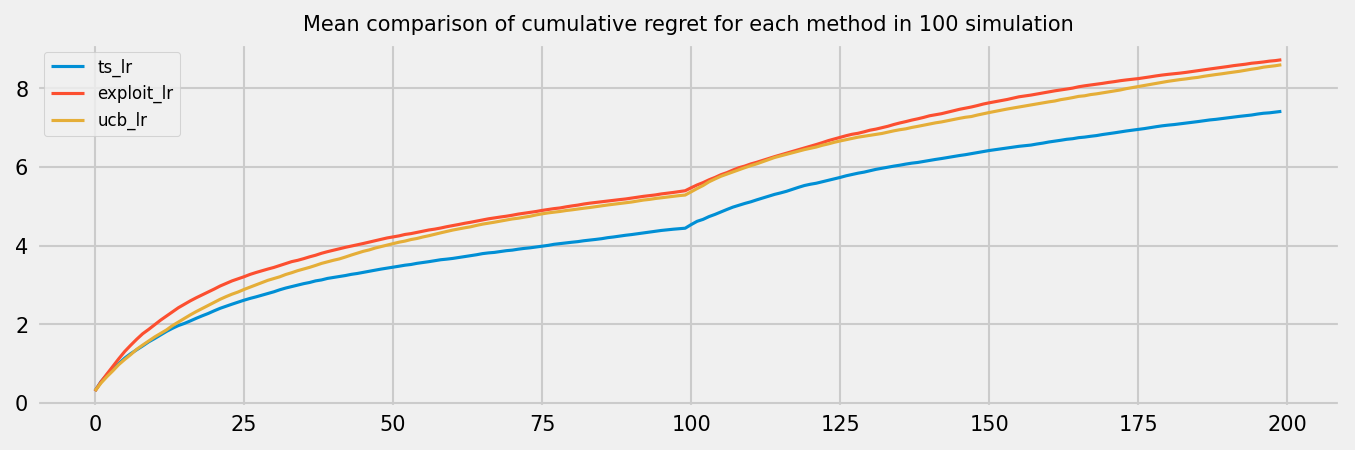

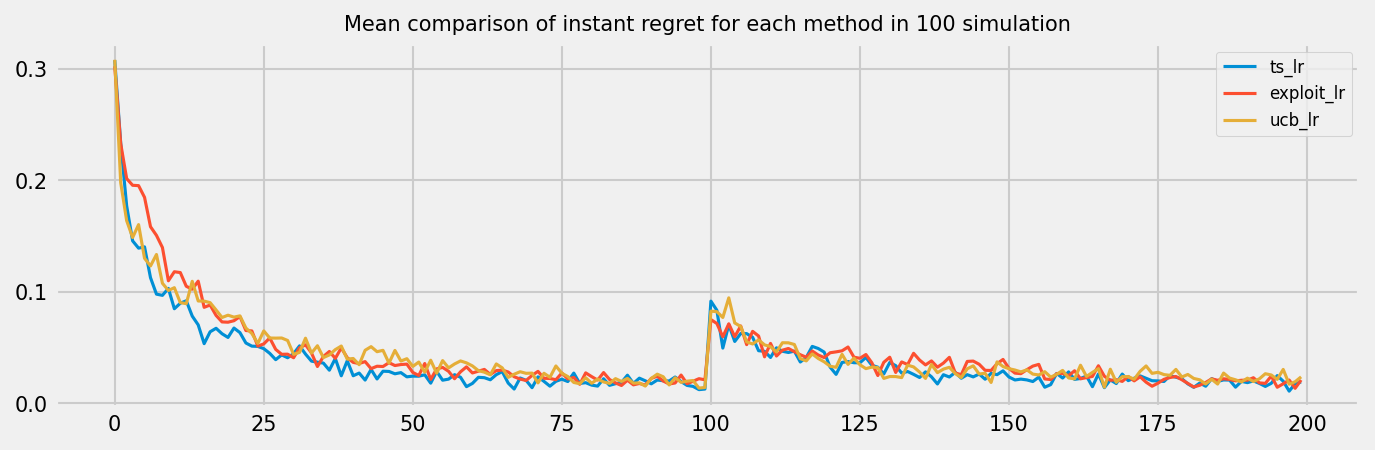

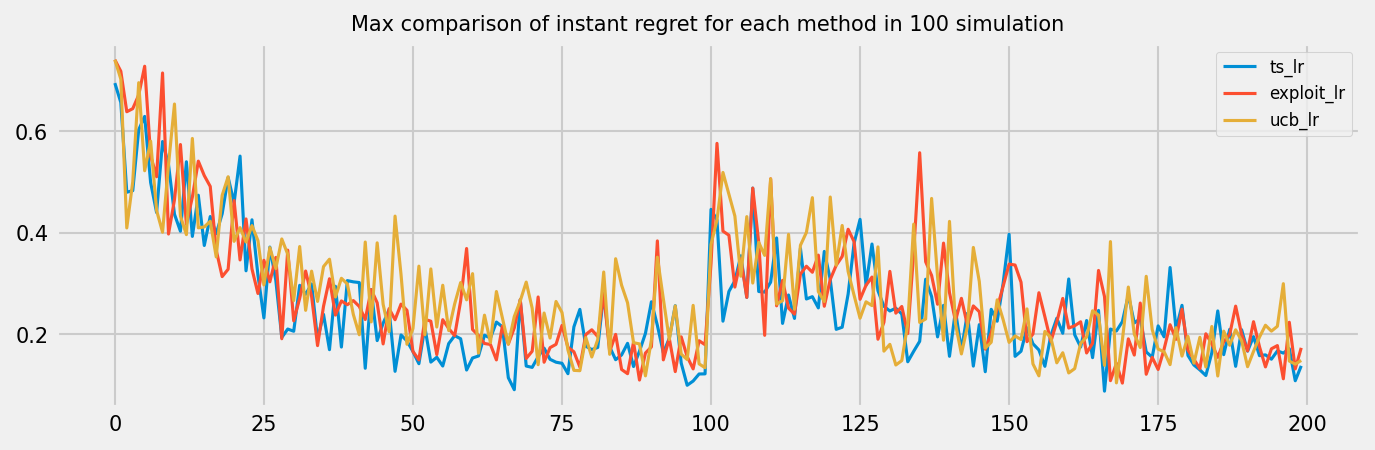

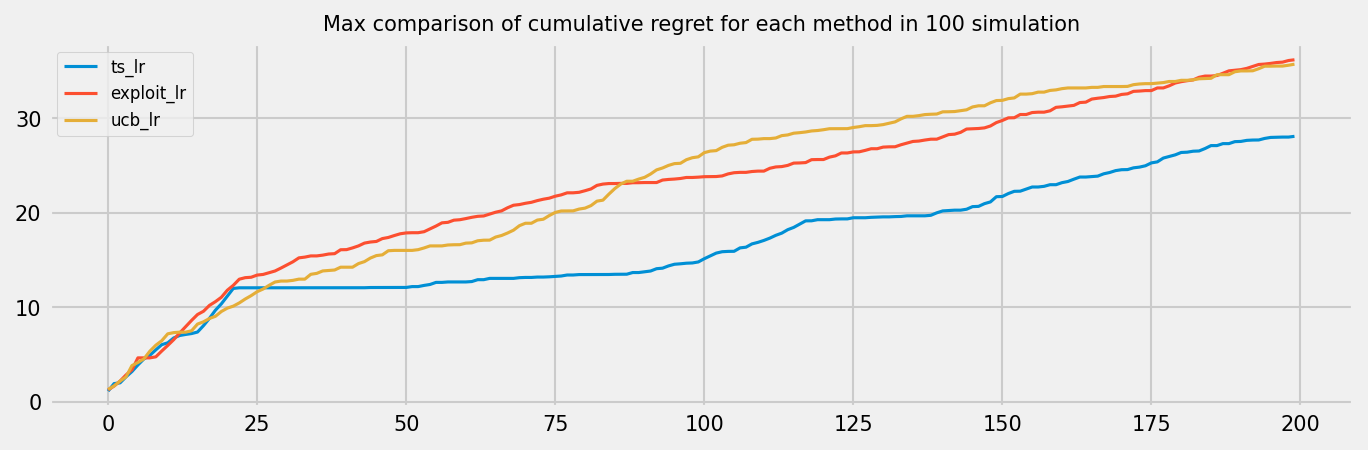

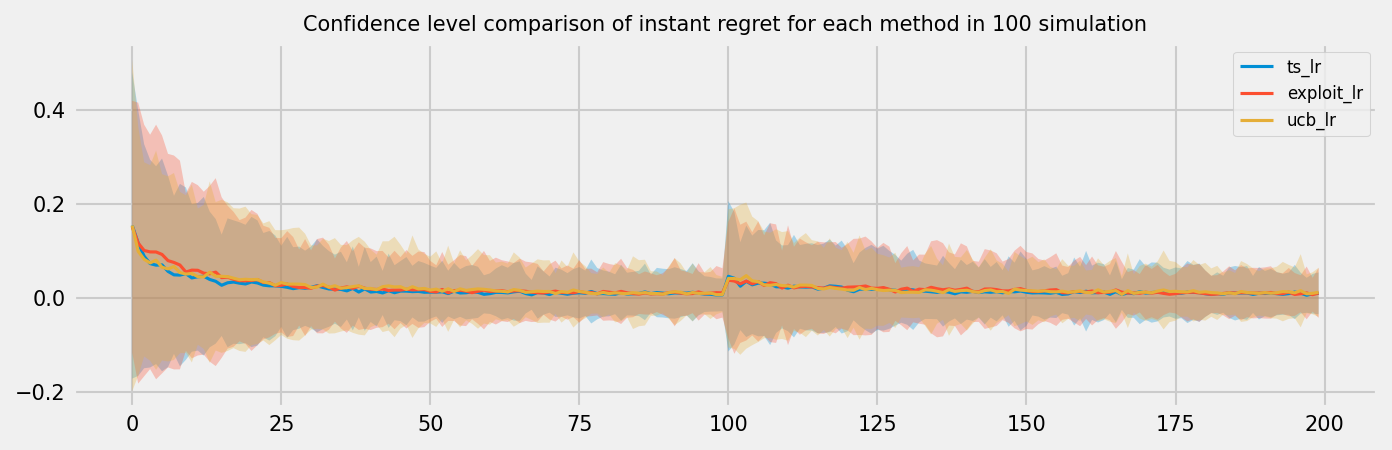

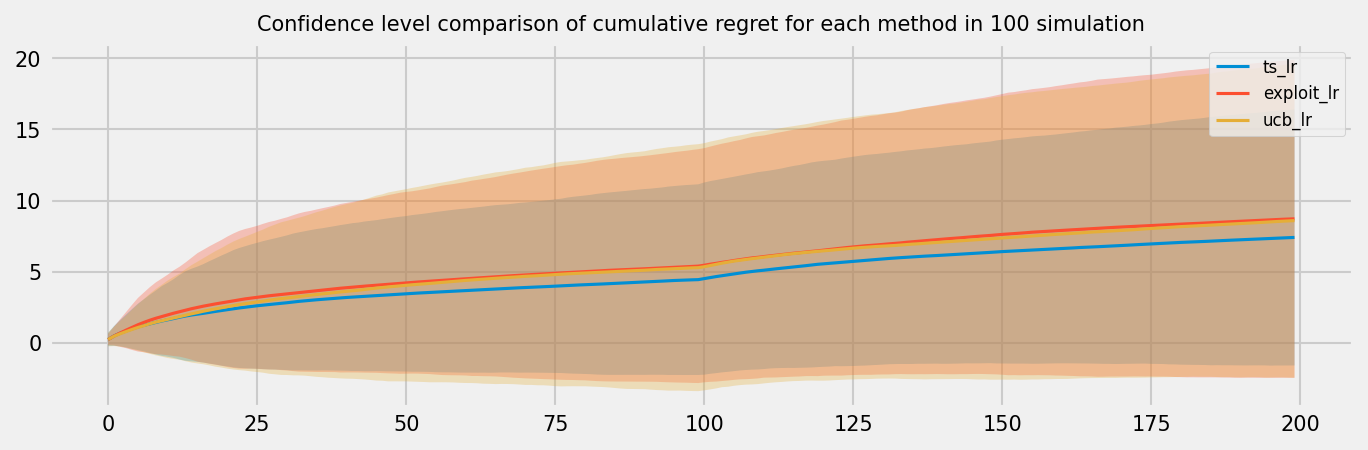

<Figure size 1500x450 with 0 Axes>

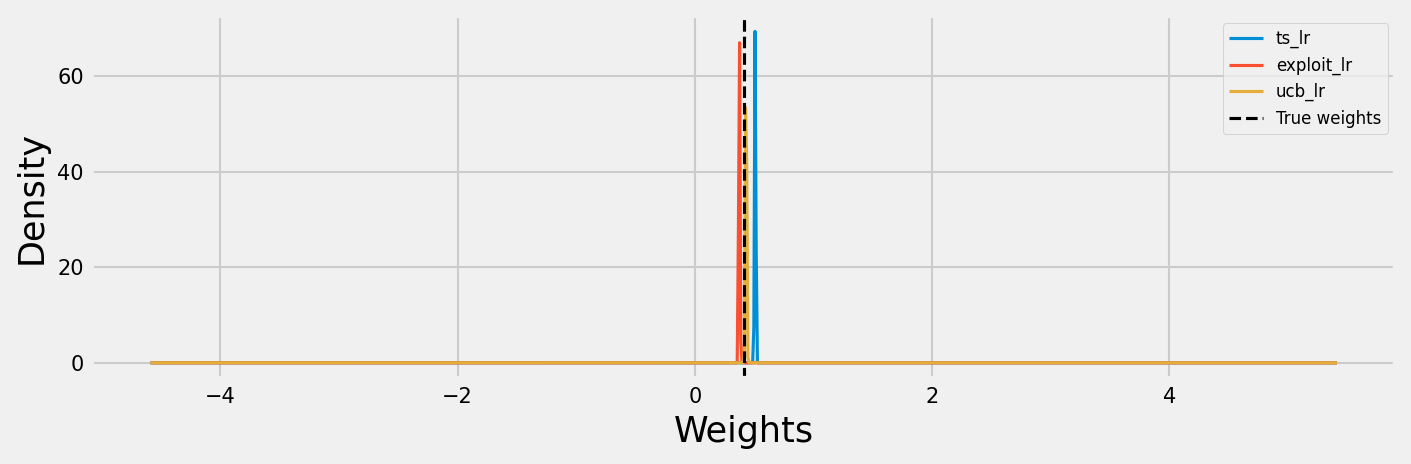

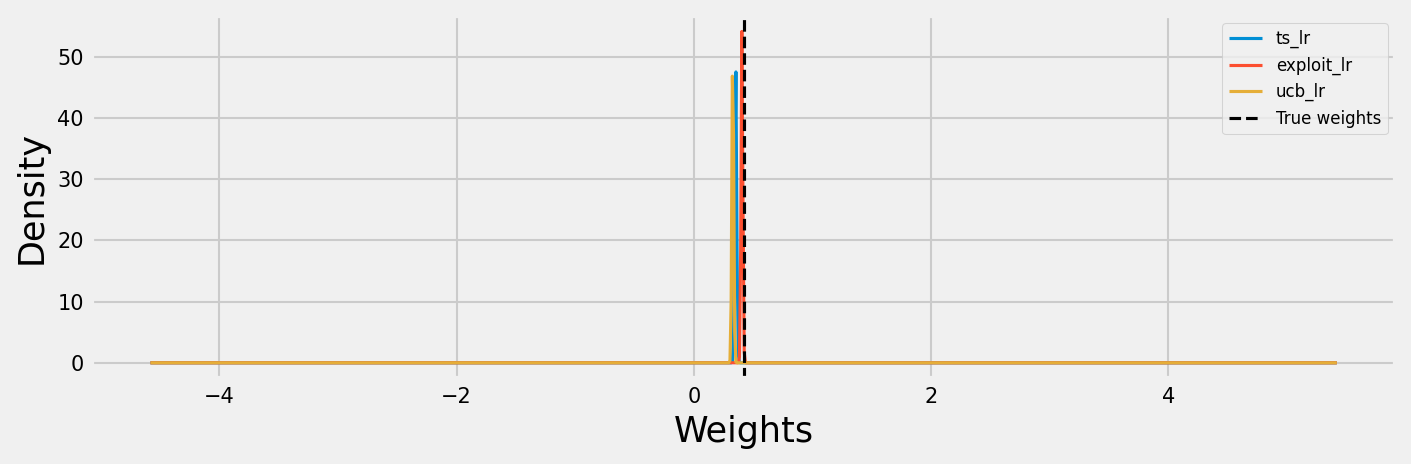

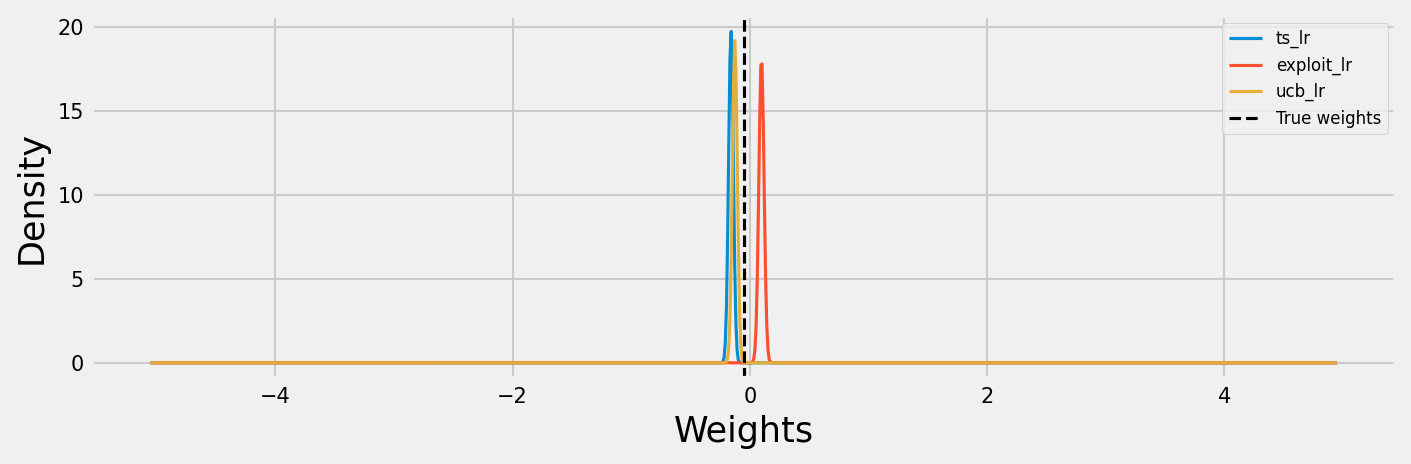

Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 2 features, lambda 10, alpha 1, 100 simulations
policy      round
ts_lr       199.0    8.926819
exploit_lr  199.0    8.290485
ucb_lr      199.0    7.621550
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 2 features, lambda 10, alpha 10, 100 simulations
policy      round
ts_lr       199.0    17.482087
exploit_lr  199.0     8.806534
ucb_lr      199.0    24.867394
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 3 features, lambda 1, alpha 0.1, 100 simulations
policy      round
ts_lr       199.0    7.966038
exploit_lr  199.0    8.102803
ucb_lr      199.0    7.343072
Name: regret_cumsum, dtype: float64
Analyzing simulation with 10 arms, 2 data points per round, 100 rounds, 3 features, lambda 1, alpha 1, 100 simulations
policy      round
ts_lr       199.0    8.483546
exploit_lr  199.0    7.818695
ucb_lr

In [14]:
# load the results from pickle
for i in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[i]
    print(f"Analyzing simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    try:
        experiment_df = pd.read_pickle(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")
    except:
        print(f"File not found for {n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}")
        continue
    
    if winning_policy(experiment_df) != 'ts_lr':
        continue

    regret_mean_multi_data_per_ground_agg = experiment_df.reset_index().groupby(['policy','round','simul_id'], sort = False)['regret'].sum()
    regret_mean = regret_mean_multi_data_per_ground_agg.groupby(['policy','round'], sort = False).mean()

    plot_regret(regret_mean, n_sims, regret_type='cumulative')
    plot_regret(regret_mean, n_sims, regret_type='instant')

    #plot cf
    plot_regret_max(experiment_df, n_sims, regret_type='instant')
    plot_regret_max(experiment_df, n_sims, regret_type='cumulative')
    #plot max
    plot_regret_cl(experiment_df, n_sims, regret_type='instant')
    plot_regret_cl(experiment_df, n_sims, regret_type='cumulative')

    # #plot weights
    weights_df = get_weights(experiment_df)
    plot_weight_distribution(weights_df)
